# Data processing

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from scipy import stats
warnings.filterwarnings('ignore')


blue   = '#3b6fb6'     
green  = '#6ebe44'     
red    = '#d62728'     
error_blue  = '#1f4a7b'
error_green = '#3a7d1f'
blue = '#3b6fb6'        
mean_color = '#2ca02c'  

## data unpacking

In [2]:
base_path = '/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/Raw/'
years = ['2025', '2024', '2023', '2022', '2021', '2020', '2019', '2018']


file_paths = {
    'prices': {},
    'total_gen': {},
    'onshore': {},
    'offshore': {},
    'solar': {},
    'generation_type': {},
    'load': {}
}

for year in years:
    file_paths['prices'][year] = f"{base_path}GUI_ENERGY_PRICES_{year}.csv"
    file_paths['total_gen'][year] = f"{base_path}GUI_TOTAL_GENERATION_FORECAST_{year}.csv"
    file_paths['onshore'][year] = f"{base_path}GUI_WIND_SOLAR_GENERATION_FORECAST_ONSHORE_{year}.csv"
    file_paths['offshore'][year] = f"{base_path}GUI_WIND_SOLAR_GENERATION_FORECAST_OFFSHORE_{year}.csv"
    file_paths['solar'][year] = f"{base_path}GUI_WIND_SOLAR_GENERATION_FORECAST_SOLAR_{year}.csv"
    file_paths['generation_type'][year] = f"{base_path}AGGREGATED_GENERATION_PER_TYPE_GENERATION_{year}.csv"
    file_paths['load'][year] = f"{base_path}GUI_TOTAL_LOAD_DAYAHEAD_{year}.csv"


def process_dataframe(df, drop_columns, rename_columns=None):

    df = df.iloc[::-1].reset_index(drop=True)
    df['datetime'] = df['MTU (UTC)'].str.split(' - ').str[0]
    df.drop(drop_columns, axis=1, inplace=True)
    if rename_columns:
        df.rename(columns=rename_columns, inplace=True)
    
    return df

df_prices = {}

for year in years:
    df = pd.read_csv(file_paths['prices'][year])
    df = process_dataframe(
        df,
        drop_columns=['MTU (UTC)', 'Area', 'Sequence', 'Intraday Period (UTC)', 'Intraday Price (EUR/MWh)'],
        rename_columns={'Day-ahead Price (EUR/MWh)': 'price'}
    )
    df = df[['datetime', 'price']]
    df_prices[year] = df

df_load = {}

for year in years:
    df = pd.read_csv(file_paths['load'][year])
    df = process_dataframe(
        df,
        drop_columns=['MTU (UTC)', 'Area']
    )
    df = df[['datetime', 'Actual Total Load (MW)', 'Day-ahead Total Load Forecast (MW)']]
    df['Actual Total Load (MW)'] = pd.to_numeric(df['Actual Total Load (MW)'], errors='coerce')
    df['Day-ahead Total Load Forecast (MW)'] = pd.to_numeric(df['Day-ahead Total Load Forecast (MW)'], errors='coerce')
    df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True, errors='coerce')
    df['datetime_hour'] = df['datetime'].dt.floor('h')
    
    df = (
        df
        .groupby('datetime_hour', as_index=False, sort=False)
        .agg({
            'Actual Total Load (MW)': 'mean',
            'Day-ahead Total Load Forecast (MW)': 'mean'
        })
        .rename(columns={'datetime_hour': 'datetime'})
    )
    
    df_load[year] = df


date_fin = pd.to_datetime('29/09/2025 23:59:59', dayfirst=True)

date_str_clean = df_prices['2025']['datetime'].str.split(' (', regex=False).str[0]
datetime_col = pd.to_datetime(date_str_clean, dayfirst=True, format='%d/%m/%Y %H:%M:%S')
mask = (datetime_col <= date_fin)

df_prices['2025'] = df_prices['2025'][mask].copy().reset_index(drop=True)

df_prices['2025']['datetime'] = pd.to_datetime(
    df_prices['2025']['datetime'],
    dayfirst=True,
    format='%d/%m/%Y %H:%M:%S'
)
df_prices['2025']['datetime_hour'] = df_prices['2025']['datetime'].dt.floor('h')

df_prices['2025'] = (
    df_prices['2025']
    .groupby('datetime_hour', as_index=False, sort=False)
    .agg({'price': 'first'})
    .rename(columns={'datetime_hour': 'datetime'})
)

mask_load = (df_load['2025']['datetime'] <= date_fin)
df_load['2025'] = df_load['2025'][mask_load].copy().reset_index(drop=True)


df_total_gen = {}

for year in years:
    df = pd.read_csv(file_paths['total_gen'][year])
    df = process_dataframe(
        df,
        drop_columns=['MTU (UTC)', 'Area', 'Scheduled Consumption (MW)']
    )
    df = df[['datetime', 'Generation Forecast (MW)', 'Actual Generation (MW)']]
    df_total_gen[year] = df


df_onshore = {}

for year in years:
    df = pd.read_csv(file_paths['onshore'][year])
    df = process_dataframe(
        df,
        drop_columns=['MTU (UTC)', 'Area', 'Intraday (MW)', 'Current (MW)'],
        rename_columns={'Day-ahead (MW)': 'Onshore forecast', 'Actual (MW)': 'Onshore actual'}
    )
    df = df[['datetime', 'Onshore forecast', 'Onshore actual']]
    df_onshore[year] = df

df_offshore = {}

for year in years:
    df = pd.read_csv(file_paths['offshore'][year])
    df = process_dataframe(
        df,
        drop_columns=['MTU (UTC)', 'Area', 'Intraday (MW)', 'Current (MW)'],
        rename_columns={'Day-ahead (MW)': 'Offshore forecast', 'Actual (MW)': 'Offshore actual'}
    )
    df = df[['datetime', 'Offshore forecast', 'Offshore actual']]
    df_offshore[year] = df

df_solar = {}

for year in years:
    df = pd.read_csv(file_paths['solar'][year])
    df = process_dataframe(
        df,
        drop_columns=['MTU (UTC)', 'Area', 'Intraday (MW)', 'Current (MW)'],
        rename_columns={'Day-ahead (MW)': 'Solar forecast', 'Actual (MW)': 'Solar actual'}
    )
    df = df[['datetime', 'Solar forecast', 'Solar actual']]
    df_solar[year] = df


df_generation_type = {}

types_to_remove = [
    'Fossil Hard Coal', 'Fossil Oil', 'Fossil Oil Shale', 
    'Fossil Peat', 'Geothermal', 'Other renewable', 
    'Fossil Coal-derived gas', 'Fossil Brown coal/Lignite', 
    'Hydro Water Reservoir', 'Marine', 'Wind Onshore', 'Wind Offshore',
    'Fossil Oil shale', 'Energy storage', 'Fossil Hard coal','Hydro Pumped Storage'
]

for year in years:
    df = pd.read_csv(file_paths['generation_type'][year])
    df = df.iloc[::-1].reset_index(drop=True)
    df['datetime'] = df['MTU (UTC)'].str.split(' - ').str[0]
    df = df[~df['Production Type'].isin(types_to_remove)]    
    df_pivot = df.pivot_table(
        index='datetime',
        columns='Production Type',
        values='Generation (MW)',
        aggfunc='first'
    ).reset_index()
    
    df_pivot.columns.name = None    
    df_generation_type[year] = df_pivot



for data_dict in [df_total_gen, df_onshore, df_offshore, df_solar, df_generation_type]:
    date_str_clean = data_dict['2025']['datetime'].str.split(' (', regex=False).str[0]
    datetime_col = pd.to_datetime(date_str_clean, dayfirst=True, format='mixed')
    mask = (datetime_col <= date_fin)
    data_dict['2025'] = data_dict['2025'][mask].copy().reset_index(drop=True)



df_all_prices = pd.concat([df_prices[year] for year in years], ignore_index=True)
df_all_prices = df_all_prices.iloc[::-1].reset_index(drop=True)


df_all_total_gen = pd.concat([df_total_gen[year] for year in years], ignore_index=True)
df_all_total_gen = df_all_total_gen.iloc[::-1].reset_index(drop=True)


df_all_onshore = pd.concat([df_onshore[year] for year in years], ignore_index=True)
df_all_onshore = df_all_onshore.iloc[::-1].reset_index(drop=True)


df_all_offshore = pd.concat([df_offshore[year] for year in years], ignore_index=True)
df_all_offshore = df_all_offshore.iloc[::-1].reset_index(drop=True)


df_all_solar = pd.concat([df_solar[year] for year in years], ignore_index=True)
df_all_solar = df_all_solar.iloc[::-1].reset_index(drop=True)


df_all_generation_type = pd.concat([df_generation_type[year] for year in years], ignore_index=True)
df_all_generation_type = df_all_generation_type.iloc[::-1].reset_index(drop=True)


df_all_load = pd.concat([df_load[year] for year in years], ignore_index=True)
df_all_load = df_all_load.iloc[::-1].reset_index(drop=True)



df_all_prices = df_all_prices.iloc[1:]


for df in [df_all_prices, df_all_total_gen, df_all_onshore, df_all_offshore, 
           df_all_solar, df_all_generation_type, df_all_load]:
    df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True, errors='coerce')


print(f"\nPrices: {len(df_all_prices)} rows")
print(df_all_prices.head(3))

print(f"\nTotal generation: {len(df_all_total_gen)} rows")
print(df_all_total_gen.head(3))

print(f"\nOnshore: {len(df_all_onshore)} rows")
print(df_all_onshore.head(3))

print(f"\nOffshore: {len(df_all_offshore)} rows")
print(df_all_offshore.head(3))

print(f"\nSolar: {len(df_all_solar)} rows")
print(df_all_solar.head(3))

print(f"\nGeneration per type: {len(df_all_generation_type)} rows")
print(f"Columns: {list(df_all_generation_type.columns)}")
print(df_all_generation_type.head(3))

print(f"\nCLoad: {len(df_all_load)} rows")
print(df_all_load.head(3))


Prices: 67896 rows
             datetime  price
1 2018-01-01 00:00:00   4.74
2 2018-01-01 01:00:00   3.66
3 2018-01-01 02:00:00   1.26

Total generation: 67896 rows
             datetime Generation Forecast (MW) Actual Generation (MW)
0 2018-01-01 00:00:00                  9788.88                9379.34
1 2018-01-01 01:00:00                  9128.67                9217.41
2 2018-01-01 02:00:00                  8868.26                8903.52

Onshore: 67896 rows
             datetime Onshore forecast Onshore actual
0 2018-01-01 00:00:00          1419.55        1100.75
1 2018-01-01 01:00:00          1413.78        1108.76
2 2018-01-01 02:00:00          1387.12        1026.03

Offshore: 67896 rows
             datetime Offshore forecast Offshore actual
0 2018-01-01 00:00:00            832.99          814.39
1 2018-01-01 01:00:00            833.41          807.19
2 2018-01-01 02:00:00            833.43          805.80

Solar: 67896 rows
             datetime Solar forecast Solar actual
0 

In [3]:
df_main = df_all_prices.copy()

In [4]:
df_main = df_main.merge(
    df_all_total_gen[['datetime', 'Generation Forecast (MW)', 'Actual Generation (MW)']],
    on='datetime',
    how='left'
)


df_main = df_main.merge(
    df_all_onshore[['datetime', 'Onshore forecast', 'Onshore actual']],
    on='datetime',
    how='left'
)

df_main = df_main.merge(
    df_all_offshore[['datetime', 'Offshore forecast', 'Offshore actual']],
    on='datetime',
    how='left'
)


df_main = df_main.merge(
    df_all_solar[['datetime', 'Solar forecast', 'Solar actual']],
    on='datetime',
    how='left'
)

df_main = df_main.merge(
    df_all_load[['datetime', 'Actual Total Load (MW)', 'Day-ahead Total Load Forecast (MW)']],
    on='datetime',
    how='left'
)

# Merge generation per type
df_main = df_main.merge(
    df_all_generation_type,
    on='datetime',
    how='left'
)

df_main = df_main.rename(columns={
    'Generation Forecast (MW)': 'total_gen_forecast',
    'Actual Generation (MW)': 'total_gen_actual',
    'Onshore forecast': 'wind_onshore_forecast',
    'Onshore actual': 'wind_onshore_actual',
    'Offshore forecast': 'wind_offshore_forecast',
    'Offshore actual': 'wind_offshore_actual',
    'Solar forecast': 'solar_forecast',
    'Solar actual': 'solar_actual',
    'Actual Total Load (MW)': 'load_actual',
    'Day-ahead Total Load Forecast (MW)': 'load_forecast',
    'Fossil Gas': 'gen_gas',
    'Nuclear': 'gen_nuclear',
    'Biomass': 'gen_biomass',
    'Hydro Run-of-river and poundage': 'gen_hydro_river',
    'Solar': 'gen_solar_actual',
    'Waste': 'gen_waste',
    'Other': 'gen_other',
})

print(f"Merged dataframe shape: {df_main.shape}")
print(df_main.columns.tolist())


Merged dataframe shape: (67896, 19)
['datetime', 'price', 'total_gen_forecast', 'total_gen_actual', 'wind_onshore_forecast', 'wind_onshore_actual', 'wind_offshore_forecast', 'wind_offshore_actual', 'solar_forecast', 'solar_actual', 'load_actual', 'load_forecast', 'gen_biomass', 'gen_gas', 'gen_hydro_river', 'gen_nuclear', 'gen_other', 'gen_solar_actual', 'gen_waste']


## Data cleaning 

In [5]:
def show_non_numerical(df):   
    problems_found = False
    
    for col in df.columns:
        if col == 'datetime':
            continue
            
        if df[col].dtype == object:
            numeric_values = pd.to_numeric(df[col], errors='coerce')
            mask_bad = numeric_values.isna() & df[col].notna()
            count = mask_bad.sum()
            
            if count > 0:
                problems_found = True
                pct = (count / len(df)) * 100
                print(f"Problems : {count} values over {len(df_main)} ({pct:.2f}%)")
                exemples = df.loc[mask_bad, col].unique()[:10]
                print(f"Exemples: {exemples}")
    
    if not problems_found:
        print("\nNo not numerical value detected")
    


show_non_numerical(df_main)

Problems : 6464 values over 67896 (9.52%)
Exemples: [' ']


In [6]:
df_clean = df_main.copy()


for col in df_clean.columns:
    if col == 'datetime':
        continue
    

    if df_clean[col].dtype == object:
        df_clean[col] = df_clean[col].replace([' ', '-', 'n/e', '', 'n.a.'], np.nan)
      
    

    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

df_clean = df_clean.sort_values('datetime').reset_index(drop=True)

In [7]:
cols_with_nan = df_clean.columns[df_clean.isna().any()].tolist()
print(cols_with_nan)

['wind_offshore_actual']


### Interesting : NaN values only in the actual values of wind offshore 

In [8]:
target_col = 'wind_offshore_actual'
limit = 24

mask = df_clean[target_col].isna()
blocks = (mask != mask.shift()).cumsum()
nan_blocks = df_clean.loc[mask].groupby(blocks).size()

big_holes = nan_blocks[nan_blocks > limit]

print(f"There are {len(big_holes)} blocks of more than {limit} NaN values\n")

if len(big_holes) > 0:
    for block_id, size in big_holes.items():
        idxs = df_clean[blocks == block_id].index
        start_idx = idxs[0]
        end_idx = idxs[-1]
        print(f"Block of {size} values : from index {start_idx} to {end_idx}")

There are 22 blocks of more than 24 NaN values

Block of 27 values : from index 2938 to 2964
Block of 28 values : from index 4905 to 4932
Block of 29 values : from index 5121 to 5149
Block of 31 values : from index 5819 to 5849
Block of 31 values : from index 10832 to 10862
Block of 32 values : from index 18033 to 18064
Block of 33 values : from index 20575 to 20607
Block of 36 values : from index 21507 to 21542
Block of 26 values : from index 22960 to 22985
Block of 26 values : from index 30040 to 30065
Block of 26 values : from index 31427 to 31452
Block of 29 values : from index 40294 to 40322
Block of 27 values : from index 41378 to 41404
Block of 26 values : from index 44721 to 44746
Block of 28 values : from index 48625 to 48652
Block of 30 values : from index 54132 to 54161
Block of 39 values : from index 55675 to 55713
Block of 41 values : from index 58070 to 58110
Block of 26 values : from index 61251 to 61276
Block of 26 values : from index 61710 to 61735
Block of 43 values :

#### We cannot interpolate because there are way too big blocks 
        -> if there's a storm for example we're not going to see it in the values at all
            -> But it will be visible the forecasts ! So it's a better approximation

In [9]:
df_clean['wind_offshore_actual'] = df_clean['wind_offshore_actual'].fillna(df_clean['wind_offshore_forecast'])

print(f"Remaining NaNs : {df_clean['wind_offshore_actual'].isna().sum()}")

Remaining NaNs : 0


## General statistics/visualisations

### On the price 

In [10]:
max_idx = df_clean['price'].idxmax()
max_datetime = df_clean.loc[max_idx, 'datetime']
min_idx = df_clean['price'].idxmin()
min_datetime = df_clean.loc[min_idx, 'datetime']


print(f"Mean price       : {df_clean['price'].mean():.2f} €/MWh")
print(f"median price     : {df_clean['price'].median():.2f} €/MWh")
print(f"Std              : {df_clean['price'].std():.2f} €/MWh")
print(f"min price        : {df_clean['price'].min():.2f} €/MWh on the {min_datetime}")
print(f"max price        : {df_clean['price'].max():.2f} €/MWh on the {max_datetime}")

Mean price       : 90.91 €/MWh
median price     : 63.98 €/MWh
Std              : 90.34 €/MWh
min price        : -500.00 €/MWh on the 2019-06-08 00:00:00
max price        : 871.00 €/MWh on the 2022-08-29 17:00:00


#### Negatives

In [11]:
negative_prices = df_clean[df_clean['price'] < 0]

if len(negative_prices) > 0:
    summ=0
    for i in negative_prices['price'] : 
        summ+=i
    
    print(f"the lowest                     : {negative_prices['price'].min():.2f} €/MWh")
    print(f"on the                         : {negative_prices[negative_prices['price'] == negative_prices['price'].min()]['datetime'].values[0]}")
    print(f"the mean of all the negatives  : {summ/len(negative_prices)}")
    

the lowest                     : -500.00 €/MWh
on the                         : 2019-06-08T00:00:00.000000000
the mean of all the negatives  : -17.687957526545908


#### Spikes

In [12]:
high = df_clean['price'].mean() + 3 * df_clean['price'].std()
spike_price = df_clean[df_clean['price'] > high]
print(f"spikes (mu + 3sig) : {len(spike_price)} periods ({len(spike_price)/len(df_clean)*100:.2f}%)")

spikes (mu + 3sig) : 1689 periods (2.49%)


#### Visualisation

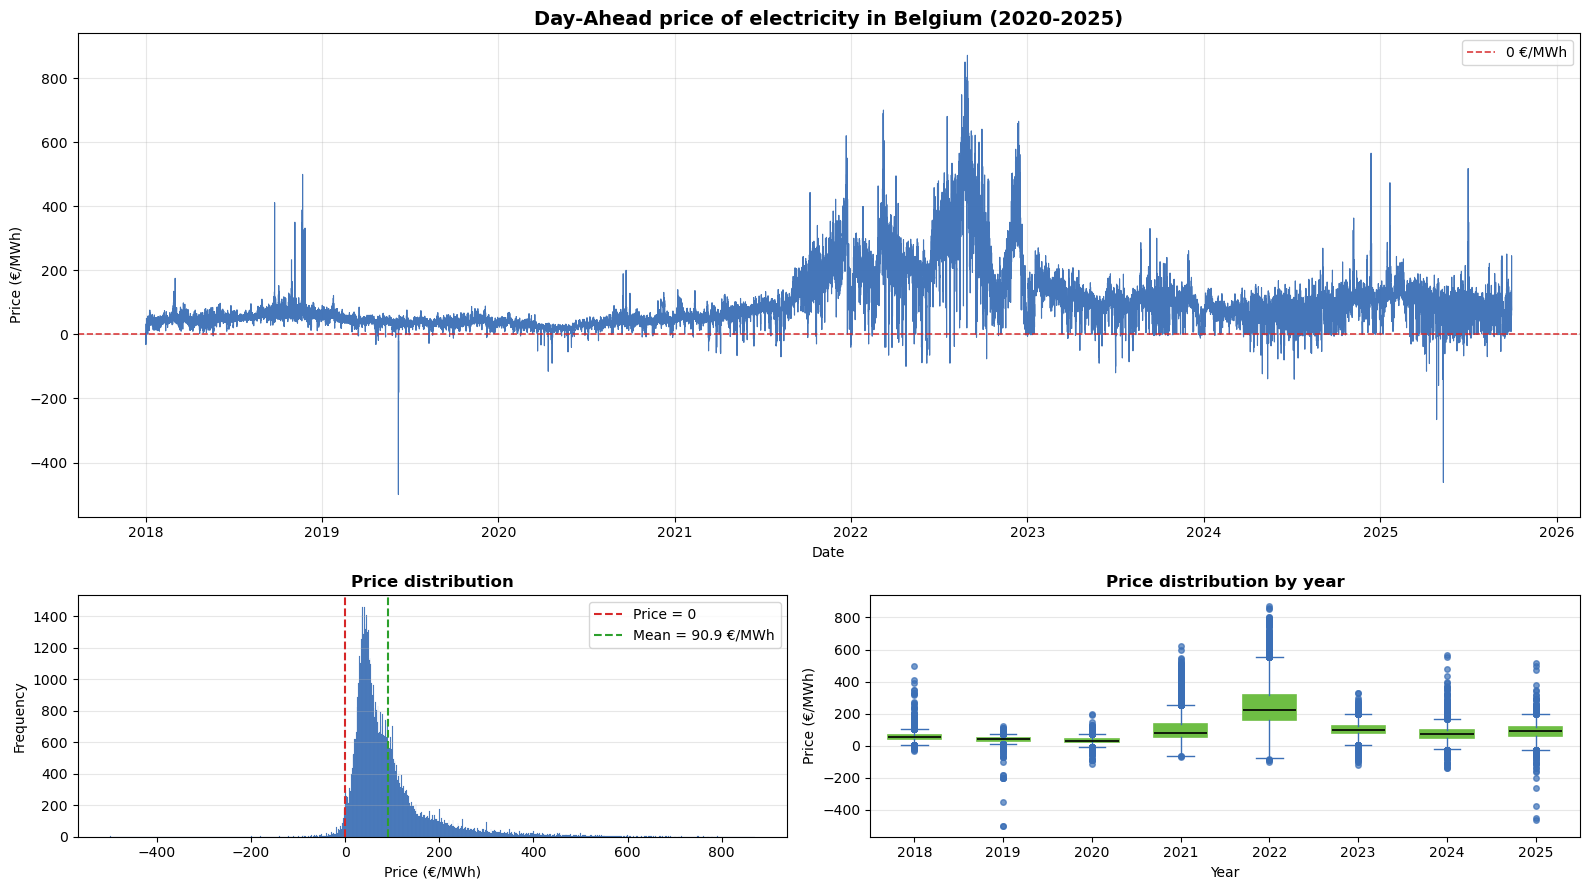

In [13]:
df_clean['year'] = df_clean['datetime'].dt.year



fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])


ax_ts = fig.add_subplot(gs[0, :])

ax_ts.plot(
    df_clean['datetime'],
    df_clean['price'],
    color=blue,
    linewidth=0.8,
    alpha=0.95
)
ax_ts.axhline(
    y=0,
    color=red,
    linestyle='--',
    linewidth=1.2,
    alpha=0.9,
    label='0 €/MWh'
)

ax_ts.set_title('Day-Ahead price of electricity in Belgium (2020-2025)',
                fontsize=14, fontweight='bold')
ax_ts.set_xlabel('Date')
ax_ts.set_ylabel('Price (€/MWh)')
ax_ts.grid(True, alpha=0.3)
ax_ts.legend()

ax_hist = fig.add_subplot(gs[1, 0])

ax_hist.hist(
    df_clean['price'],
    bins=800,
    color=blue,          
    alpha=0.9,
    edgecolor=blue,     
    linewidth=0.1
)
ax_hist.axvline(
    x=0,
    color=red,
    linestyle='--',
    linewidth=1.5,
    label='Price = 0'
)
ax_hist.axvline(
    x=df_clean['price'].mean(),
    color=mean_color,
    linestyle='--',
    linewidth=1.5,
    label=f'Mean = {df_clean["price"].mean():.1f} €/MWh'
)

ax_hist.set_title('Price distribution', fontsize=12, fontweight='bold')
ax_hist.set_xlabel('Price (€/MWh)')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(True, alpha=0.3, axis='y')
ax_hist.legend()


ax_box = fig.add_subplot(gs[1, 1])

years = sorted(df_clean['year'].unique())
data_per_year = [df_clean.loc[df_clean['year'] == y, 'price'].values for y in years]

box = ax_box.boxplot(
    data_per_year,
    labels=years,
    patch_artist=True,
    widths=0.6,
    medianprops=dict(color='black', linewidth=1.2),
    boxprops=dict(color=green, linewidth=1.2),        
    whiskerprops=dict(color=blue, linewidth=1.0),            
    capprops=dict(color=blue, linewidth=1.0),
    flierprops=dict(                                        
        marker='o',
        markerfacecolor=blue,
        markeredgecolor=blue,
        alpha=0.7,
        markersize=4
    ),
)

for patch in box['boxes']:
    patch.set_facecolor(green)

ax_box.set_xlabel('Year')
ax_box.set_ylabel('Price (€/MWh)')
ax_box.set_title('Price distribution by year', fontsize=12, fontweight='bold')
ax_box.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### Observations : 

#### Time series
    -> The day-ahead price is relatively low and stable until around 2020, then becomes much more volatile and expensive from 2021–2022    onward, with several extreme spikes and a few negative-price events.

#### Distribution
    -> Most prices lie between 0 and about 150 €/MWh, but the long right tail shows a few very high values that pull the mean up to around  90 €/MWh, indicating a highly skewed distribution.

#### Boxes
    -> From 2018 to 2020 prices are lower and less dispersed; in 2021–2022 both the median price and the spread jump sharply, with 2022 showing the highest and most volatile prices, before a partial normalization in 2023–2025.

### Problem detection 

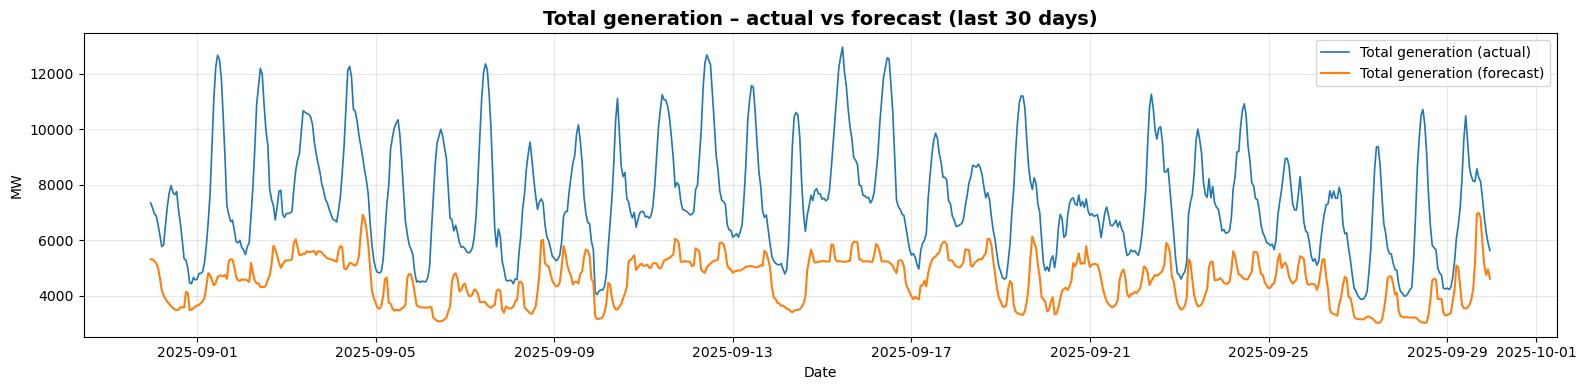

In [14]:
recent = df_clean[df_clean['datetime'] >= df_clean['datetime'].max() - pd.Timedelta(days=30)].copy()

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

ax.plot(recent['datetime'], recent['total_gen_actual'],
        label="Total generation (actual)", linewidth=1.2)
ax.plot(recent['datetime'], recent['total_gen_forecast'],
        label="Total generation (forecast)")


ax.set_title("Total generation – actual vs forecast (last 30 days)",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("MW")

ax.grid(alpha=0.3)
ax.legend(loc="best")

plt.tight_layout()
plt.show()

#### There is CLEARLY a problem...
    -> Looks like the forecasts doesnt take in accout certain types of generators. But that's really strange
            -> Maybe the main renewable ? 

In [15]:
print(recent[['solar_actual', 'wind_onshore_actual', 'wind_offshore_actual']].sum())
print(recent['total_gen_actual'].mean())
print(recent['total_gen_forecast'].mean())

solar_actual            977982.43
wind_onshore_actual     533803.70
wind_offshore_actual    748073.38
dtype: float64
7443.793259361996
4553.219611650486


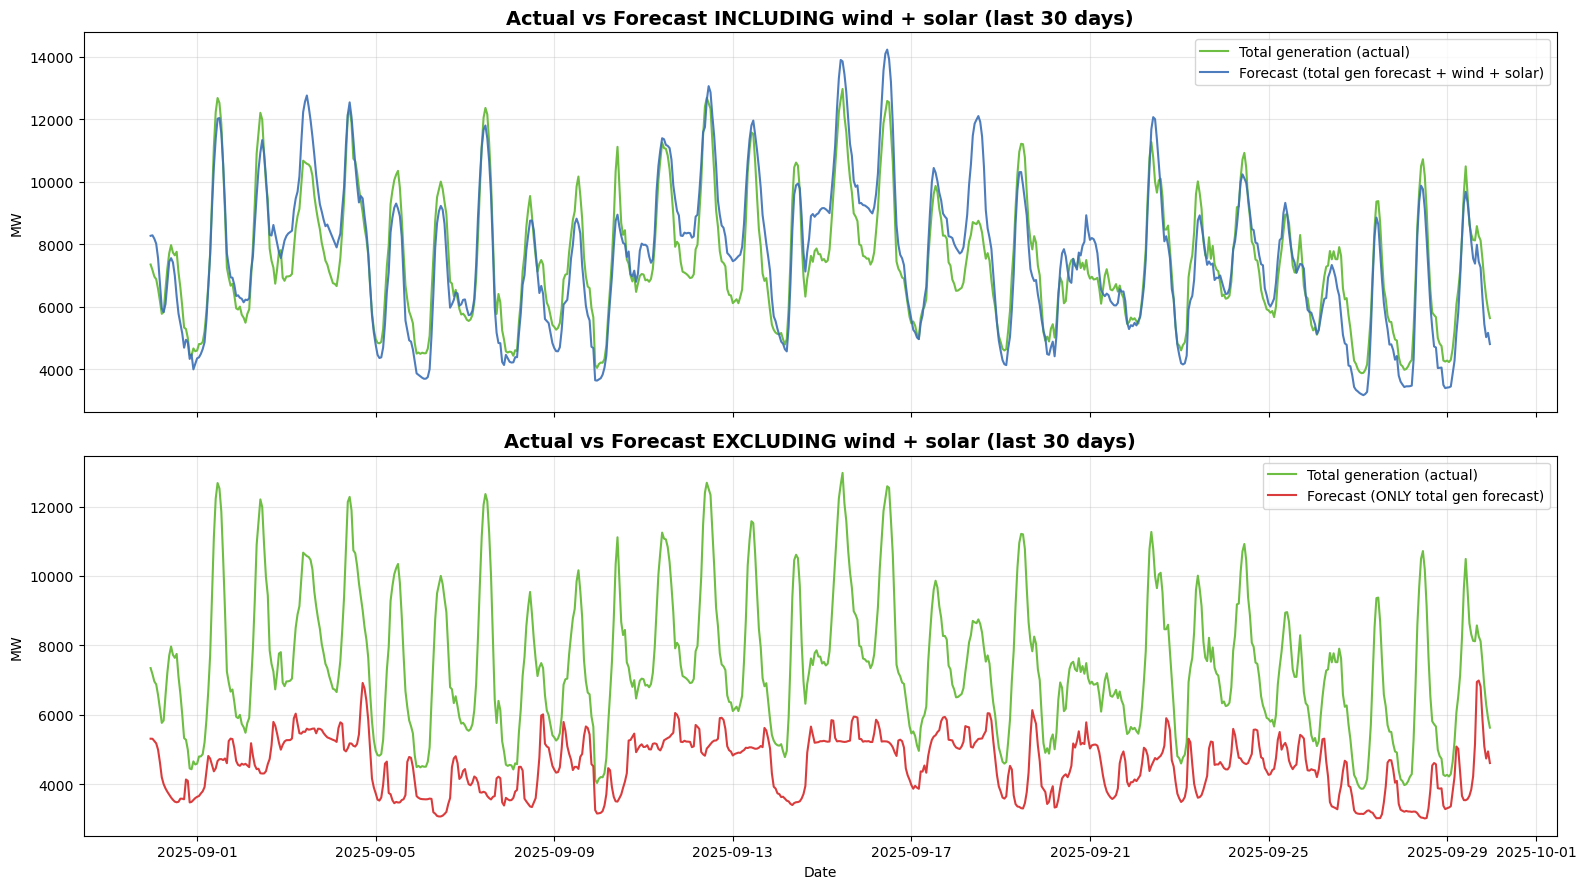

In [16]:
recent['total_forecast_with_RES'] = (
    recent['total_gen_forecast']
    + recent['solar_forecast']
    + recent['wind_onshore_forecast']
    + recent['wind_offshore_forecast']
)


    

fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)


axes[0].plot(
    recent['datetime'], recent['total_gen_actual'],
    label='Total generation (actual)',
    color=green, linewidth=1.5
)

axes[0].plot(
    recent['datetime'], recent['total_forecast_with_RES'],
    label='Forecast (total gen forecast + wind + solar)',
    color=blue, linewidth=1.5, alpha=0.9
)

axes[0].set_title('Actual vs Forecast INCLUDING wind + solar (last 30 days)',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('MW')
axes[0].legend()
axes[0].grid(alpha=0.3)


axes[1].plot(
    recent['datetime'], recent['total_gen_actual'],
    label='Total generation (actual)',
    color=green, linewidth=1.5
)

axes[1].plot(
    recent['datetime'], recent['total_gen_forecast'],
    label='Forecast (ONLY total gen forecast)',
    color=red, linewidth=1.5, alpha=0.9
)

axes[1].set_title('Actual vs Forecast EXCLUDING wind + solar (last 30 days)',
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('MW')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### Looks WAY better !
#### lets now see in the past 

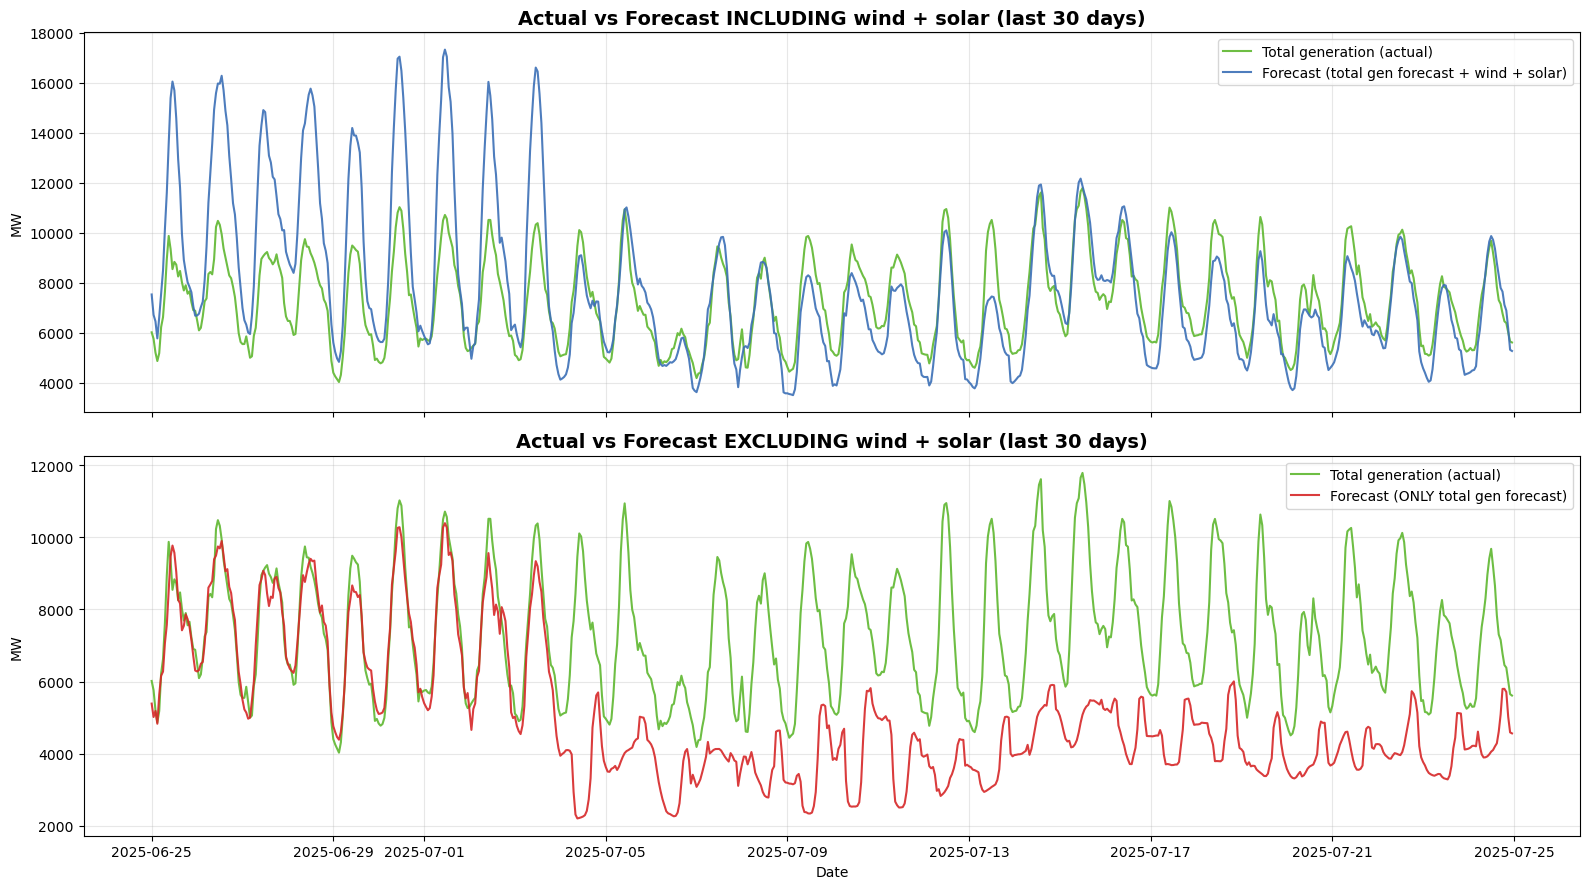

In [17]:
start = pd.Timestamp('2025-06-25')         
end   = start + pd.Timedelta(days=30)      

recent = df_clean[ (df_clean['datetime'] >= start) & (df_clean['datetime'] <  end)].copy()


recent['total_forecast_with_RES'] = (
    recent['total_gen_forecast']
    + recent['solar_forecast']
    + recent['wind_onshore_forecast']
    + recent['wind_offshore_forecast']
)


blue   = '#3b6fb6'     
green  = '#6ebe44'     
red    = '#d62728'     

fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)


axes[0].plot(
    recent['datetime'], recent['total_gen_actual'],
    label='Total generation (actual)',
    color=green, linewidth=1.5
)

axes[0].plot(
    recent['datetime'], recent['total_forecast_with_RES'],
    label='Forecast (total gen forecast + wind + solar)',
    color=blue, linewidth=1.5, alpha=0.9
)

axes[0].set_title('Actual vs Forecast INCLUDING wind + solar (last 30 days)',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('MW')
axes[0].legend()
axes[0].grid(alpha=0.3)


axes[1].plot(
    recent['datetime'], recent['total_gen_actual'],
    label='Total generation (actual)',
    color=green, linewidth=1.5
)

axes[1].plot(
    recent['datetime'], recent['total_gen_forecast'],
    label='Forecast (ONLY total gen forecast)',
    color=red, linewidth=1.5, alpha=0.9
)

axes[1].set_title('Actual vs Forecast EXCLUDING wind + solar (last 30 days)',
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('MW')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### Here the tendency has reversed...

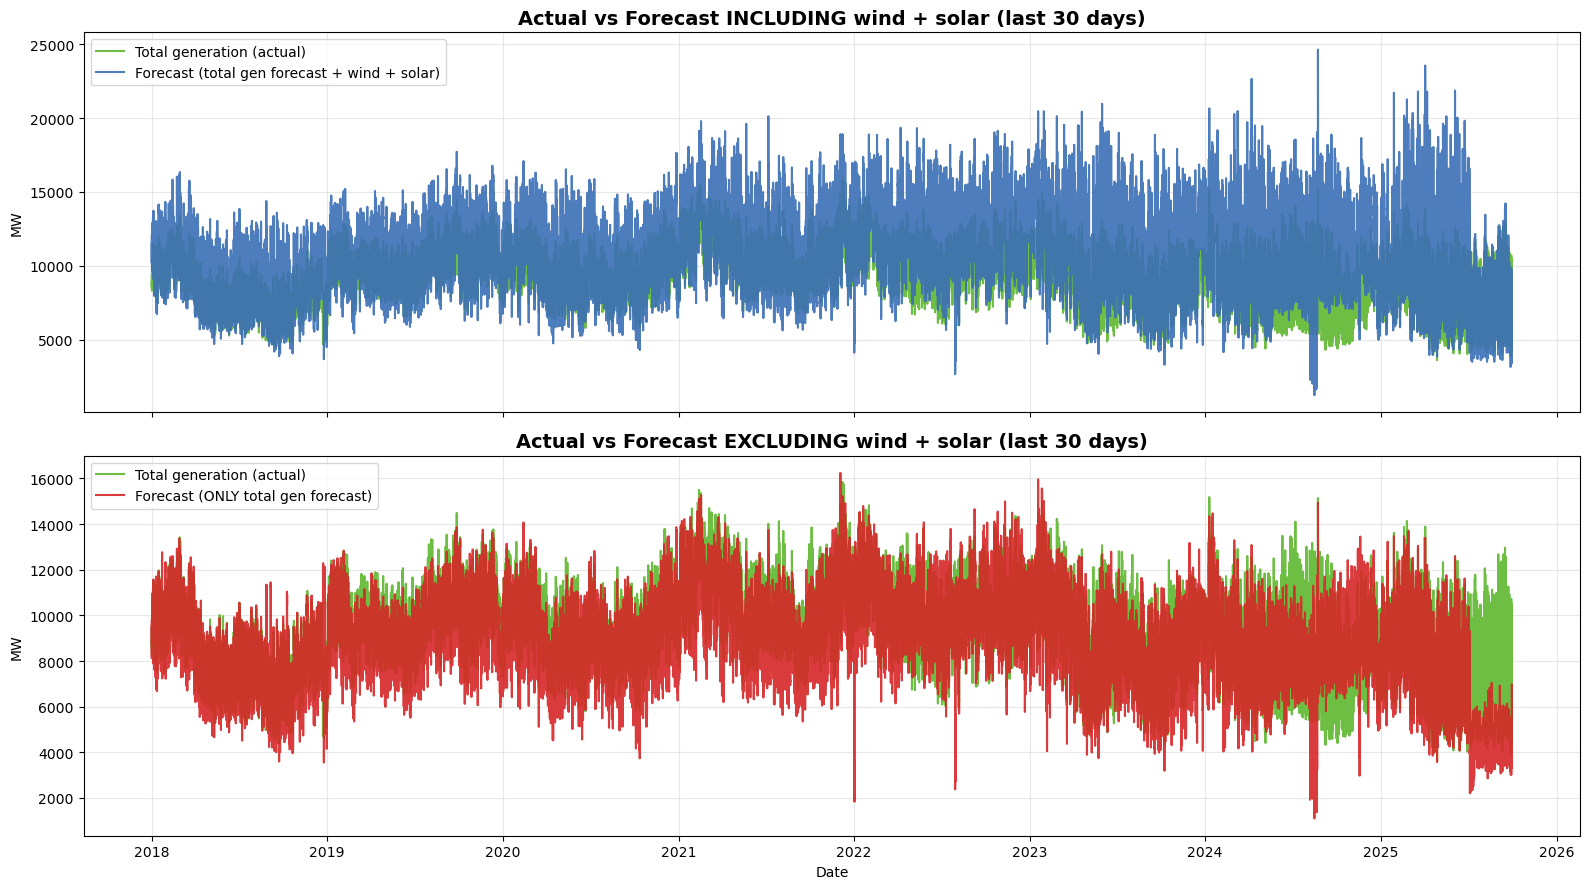

In [18]:
recent = df_clean[df_clean['datetime'] >= df_clean['datetime'].max() - pd.Timedelta(days=60000)].copy()


recent['total_forecast_with_RES'] = (
    recent['total_gen_forecast']
    + recent['solar_forecast']
    + recent['wind_onshore_forecast']
    + recent['wind_offshore_forecast']
)



fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)


axes[0].plot(
    recent['datetime'], recent['total_gen_actual'],
    label='Total generation (actual)',
    color=green, linewidth=1.5
)

axes[0].plot(
    recent['datetime'], recent['total_forecast_with_RES'],
    label='Forecast (total gen forecast + wind + solar)',
    color=blue, linewidth=1.5, alpha=0.9
)

axes[0].set_title('Actual vs Forecast INCLUDING wind + solar (last 30 days)',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('MW')
axes[0].legend()
axes[0].grid(alpha=0.3)


axes[1].plot(
    recent['datetime'], recent['total_gen_actual'],
    label='Total generation (actual)',
    color=green, linewidth=1.5
)

axes[1].plot(
    recent['datetime'], recent['total_gen_forecast'],
    label='Forecast (ONLY total gen forecast)',
    color=red, linewidth=1.5, alpha=0.9
)

axes[1].set_title('Actual vs Forecast EXCLUDING wind + solar (last 30 days)',
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('MW')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### Something happend in early july 2025...

#### To have clean datas and dont take any risks in modelisation i have to cut it out !

In [19]:
cut_date = pd.Timestamp('2025-07-04')
df_real=df_clean.copy()
df_real = df_real[df_real['datetime'] <= cut_date].copy()

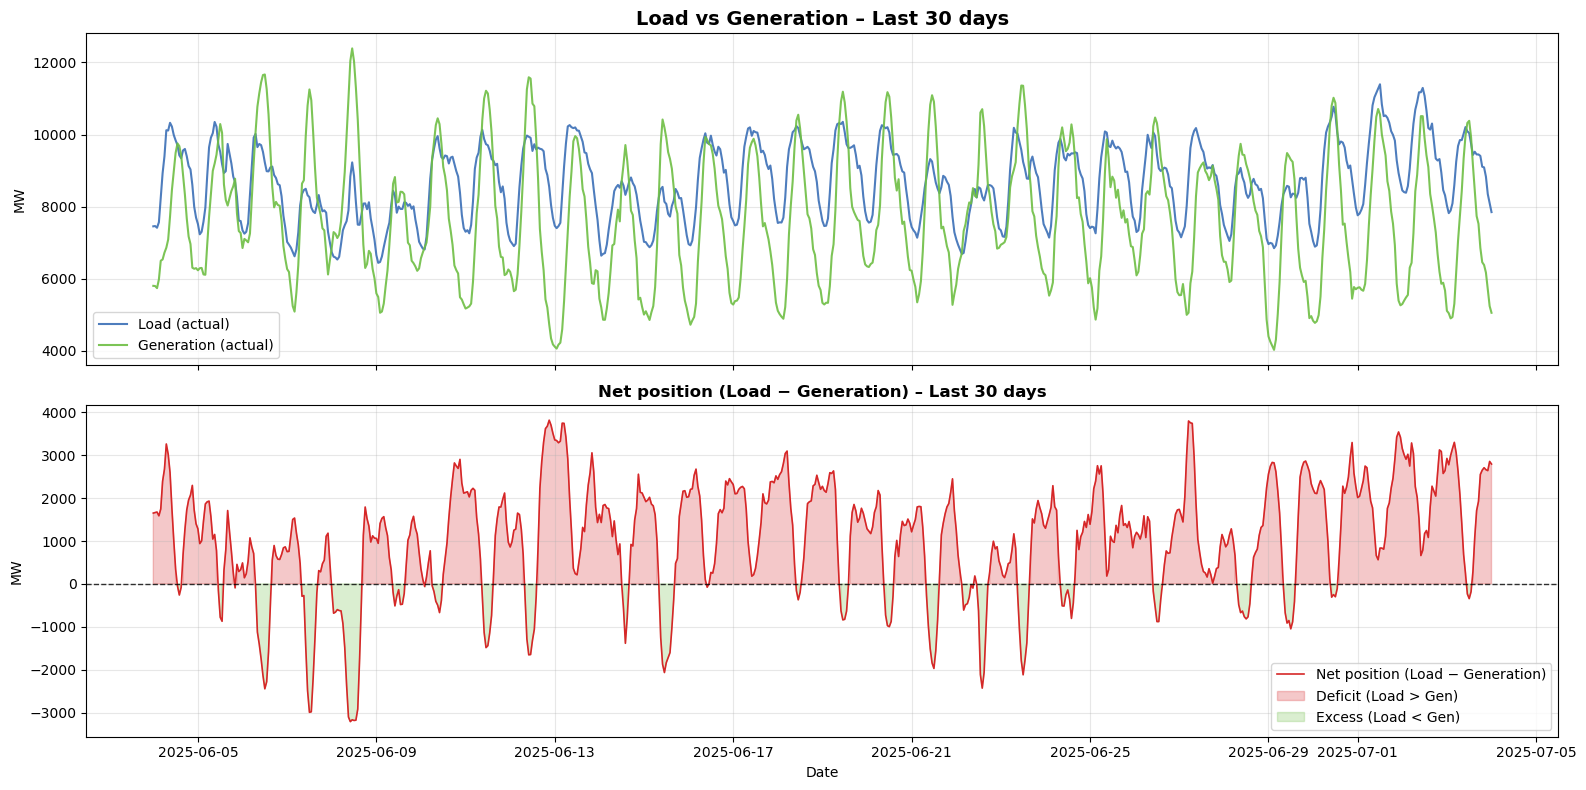

In [20]:
recentbis = df_real[df_real['datetime'] >= df_real['datetime'].max() - pd.Timedelta(days=30)].copy()
recentbis['net_position'] = recentbis['load_actual'] - recentbis['total_gen_actual']

fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

ax0 = axes[0]

ax0.plot(
    recentbis['datetime'], recentbis['load_actual'],
    label='Load (actual)', linewidth=1.5,
    alpha=0.9, color=blue
)
ax0.plot(
    recentbis['datetime'], recentbis['total_gen_actual'],
    label='Generation (actual)', linewidth=1.5,
    alpha=0.9, color=green
)

ax0.set_title('Load vs Generation – Last 30 days',
              fontsize=14, fontweight='bold')
ax0.set_ylabel('MW')
ax0.legend()
ax0.grid(alpha=0.3)

ax1 = axes[1]

ax1.plot(
    recentbis['datetime'], recentbis['net_position'],
    color=red, linewidth=1.2,
    label='Net position (Load − Generation)'
)


ax1.axhline(y=0, linestyle='--', alpha=0.8, linewidth=1.0, color='black')

ax1.fill_between(
    recentbis['datetime'], 0, recentbis['net_position'],
    where=recentbis['net_position'] > 0,
    alpha=0.25, color=red, label='Deficit (Load > Gen)'
)
ax1.fill_between(
    recentbis['datetime'], 0, recentbis['net_position'],
    where=recentbis['net_position'] < 0,
    alpha=0.25, color=green, label='Excess (Load < Gen)'
)

ax1.set_title('Net position (Load − Generation) – Last 30 days',
              fontsize=12, fontweight='bold')
ax1.set_ylabel('MW')
ax1.set_xlabel('Date')
ax1.legend()
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### That doesnt take in acount the inports !

#### By taking import/exports in account => should be more stable 

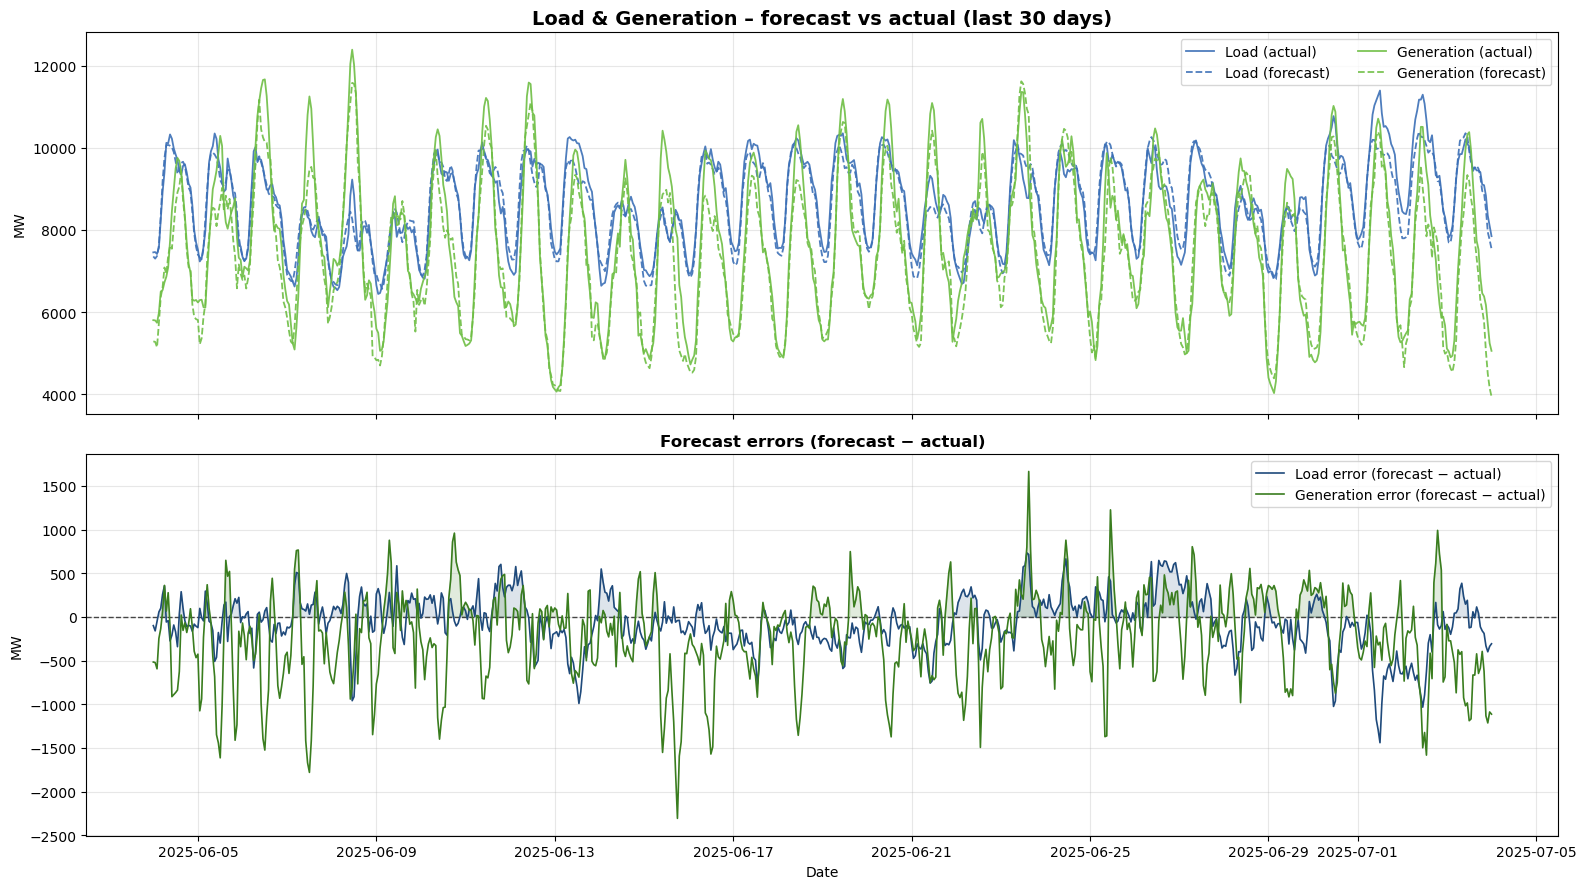

In [21]:
recentbis['load_error'] = recentbis['load_forecast'] - recentbis['load_actual']
recentbis['gen_error']  = recentbis['total_gen_forecast'] - recentbis['total_gen_actual']



fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)


axes[0].plot(
    recentbis['datetime'], recentbis['load_actual'],
    label='Load (actual)', color=blue, linewidth=1.3, alpha=0.9
)
axes[0].plot(
    recentbis['datetime'], recentbis['load_forecast'],
    label='Load (forecast)', color=blue, linestyle='--', linewidth=1.3, alpha=0.9
)

axes[0].plot(
    recentbis['datetime'], recentbis['total_gen_actual'],
    label='Generation (actual)', color=green, linewidth=1.3, alpha=0.9
)
axes[0].plot(
    recentbis['datetime'], recentbis['total_gen_forecast'],
    label='Generation (forecast)', color=green, linestyle='--', linewidth=1.3, alpha=0.9
)

axes[0].set_title('Load & Generation – forecast vs actual (last 30 days)',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('MW')
axes[0].grid(alpha=0.3)
axes[0].legend(ncol=2)


axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1.0, alpha=0.7)

axes[1].plot(
    recentbis['datetime'], recentbis['load_error'],
    label='Load error (forecast − actual)', color=error_blue, linewidth=1.2
)
axes[1].plot(
    recentbis['datetime'], recentbis['gen_error'],
    label='Generation error (forecast − actual)', color=error_green, linewidth=1.2
)

axes[1].fill_between(
    recentbis['datetime'], 0, recentbis['load_error'],
    where=recentbis['load_error'] > 0, color=error_blue, alpha=0.15
)
axes[1].fill_between(
    recentbis['datetime'], 0, recentbis['gen_error'],
    where=recentbis['gen_error'] > 0, color=error_green, alpha=0.15
)

axes[1].set_title('Forecast errors (forecast − actual)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MW')
axes[1].set_xlabel('Date')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()



#### Looks WAY better. But the generation error is much more volatile than the load error
    -> Easily understandable when we know that renewable energy is volatile by definition

In [22]:
print(df_real.columns.tolist())

['datetime', 'price', 'total_gen_forecast', 'total_gen_actual', 'wind_onshore_forecast', 'wind_onshore_actual', 'wind_offshore_forecast', 'wind_offshore_actual', 'solar_forecast', 'solar_actual', 'load_actual', 'load_forecast', 'gen_biomass', 'gen_gas', 'gen_hydro_river', 'gen_nuclear', 'gen_other', 'gen_solar_actual', 'gen_waste', 'year']


### Visualisation : price vs generation

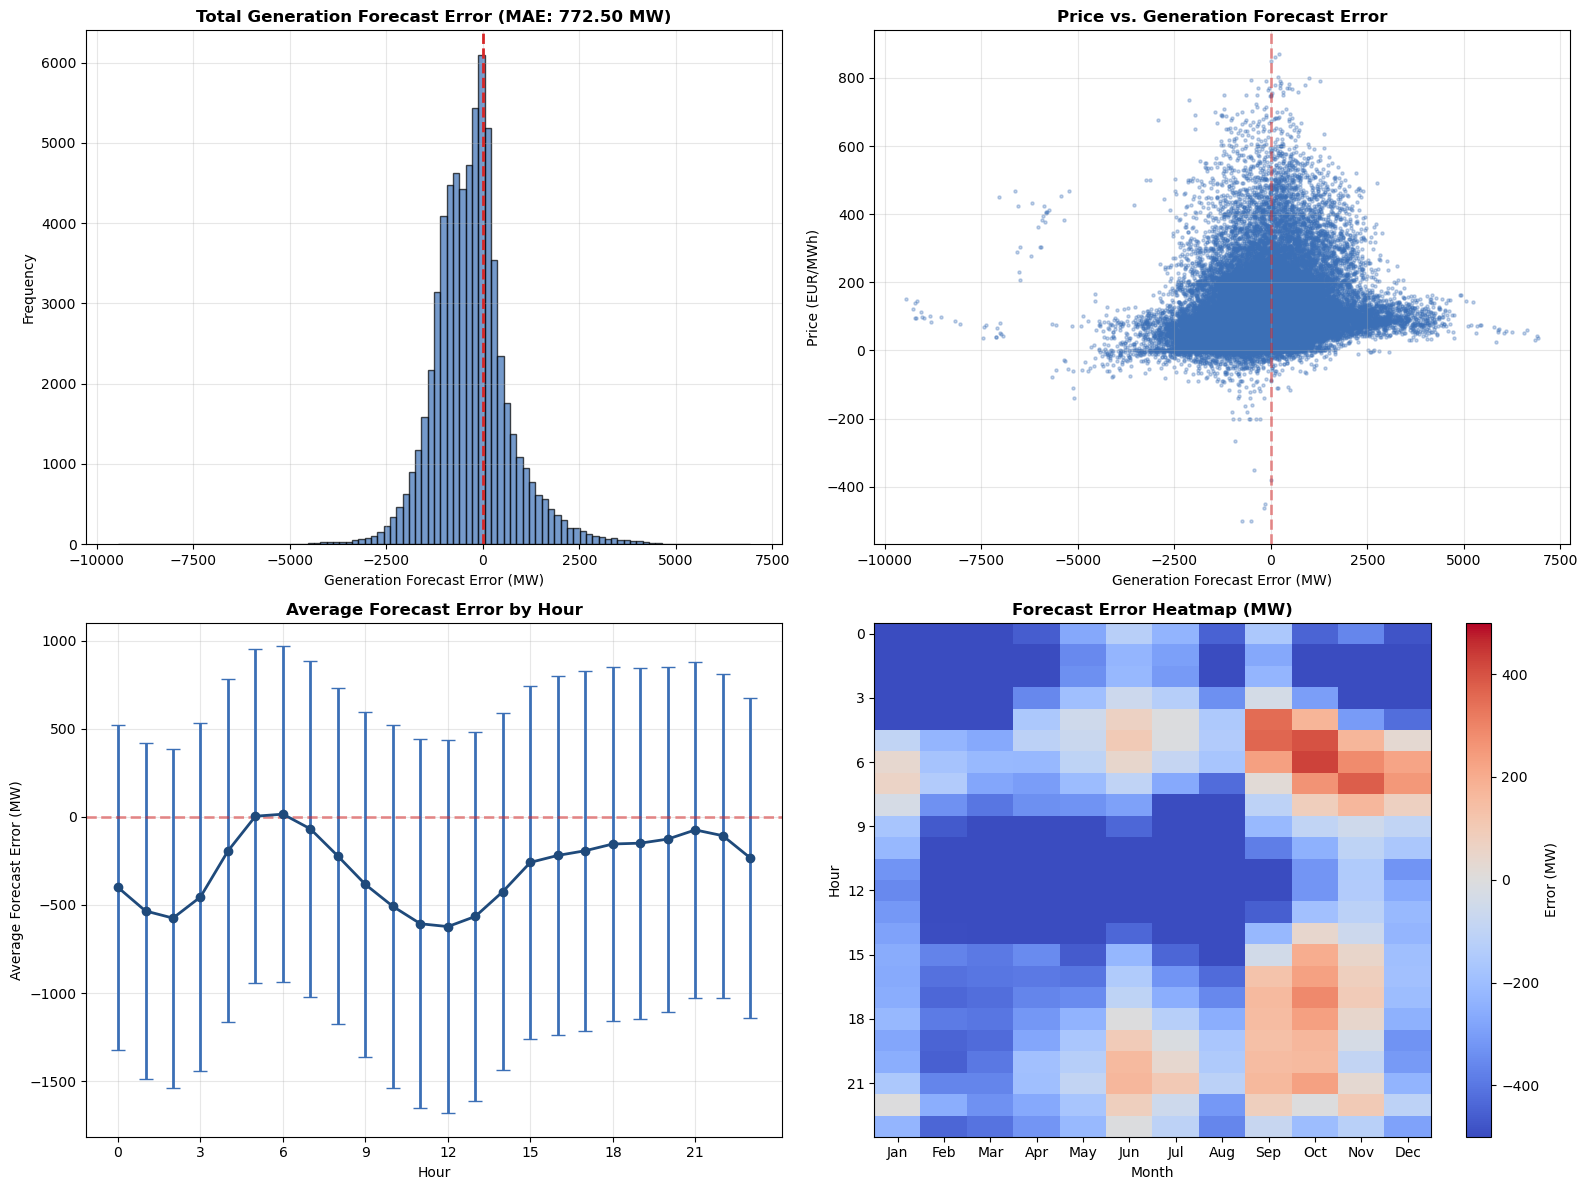

In [27]:
df_real['forecast_error'] = df_real['total_gen_forecast'] - df_real['total_gen_actual']
df_real['wind_onshore_error'] = df_real['wind_onshore_forecast'] - df_real['wind_onshore_actual']
df_real['wind_offshore_error'] = df_real['wind_offshore_forecast'] - df_real['wind_offshore_actual']
df_real['load_error'] = df_real['load_forecast'] - df_real['load_actual']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))


axes[0, 0].hist(df_real['forecast_error'], bins=100, edgecolor='black', alpha=0.7, color=blue)
axes[0, 0].axvline(0, color=red, linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Generation Forecast Error (MW)')
axes[0, 0].set_ylabel('Frequency')
mae = abs(df_real['forecast_error']).mean()
axes[0, 0].set_title(f'Total Generation Forecast Error (MAE: {mae:.2f} MW)', fontweight='bold')
axes[0, 0].grid(alpha=0.3)


axes[0, 1].scatter(df_real['forecast_error'], df_real['price'], alpha=0.3, s=5, color=blue)
axes[0, 1].axvline(0, color=red, linestyle='--', alpha=0.5, linewidth=2)
axes[0, 1].set_xlabel('Generation Forecast Error (MW)')
axes[0, 1].set_ylabel('Price (EUR/MWh)')
axes[0, 1].set_title('Price vs. Generation Forecast Error', fontweight='bold')
axes[0, 1].grid(alpha=0.3)


df_real['hour'] = df_real['datetime'].dt.hour   

hourly_error = (
    df_real
    .groupby('hour')['forecast_error']
    .agg(['mean', 'std'])
)

axes[1, 0].errorbar(hourly_error.index, hourly_error['mean'], yerr=hourly_error['std'],
                    marker='o', capsize=5, linewidth=2, markersize=6, color=error_blue, ecolor=blue)
axes[1, 0].axhline(0, color=red, linestyle='--', alpha=0.5, linewidth=2)
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Average Forecast Error (MW)')
axes[1, 0].set_title('Average Forecast Error by Hour', fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(range(0, 24, 3))


df_real['month'] = df_real['datetime'].dt.month
pivot_error = df_real.pivot_table(values='forecast_error', index='hour', columns='month', aggfunc='mean')
im = axes[1, 1].imshow(pivot_error.values, cmap='coolwarm', aspect='auto', vmin=-500, vmax=500)
axes[1, 1].set_yticks(range(0, 24, 3))
axes[1, 1].set_yticklabels(range(0, 24, 3))
axes[1, 1].set_xticks(range(12))
axes[1, 1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
axes[1, 1].set_ylabel('Hour')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_title('Forecast Error Heatmap (MW)', fontweight='bold')
plt.colorbar(im, ax=axes[1, 1], label='Error (MW)')

plt.tight_layout()
plt.show()

#### These plots show how good the generation forecasts are. We see that when the forecasts are not good, they will more underestimate the production than overestimate it. That doesn't change the fact that it's rarely extremely accurate.

#### We can clearly see a "cross" shape, on the zeros of both axis, on the upper right plot. The intuition i have behind it is that when the predictions are accurate (mainly when we have either very bad or very good conditions) the prices are very high or very low !

### Visualisation : renewable

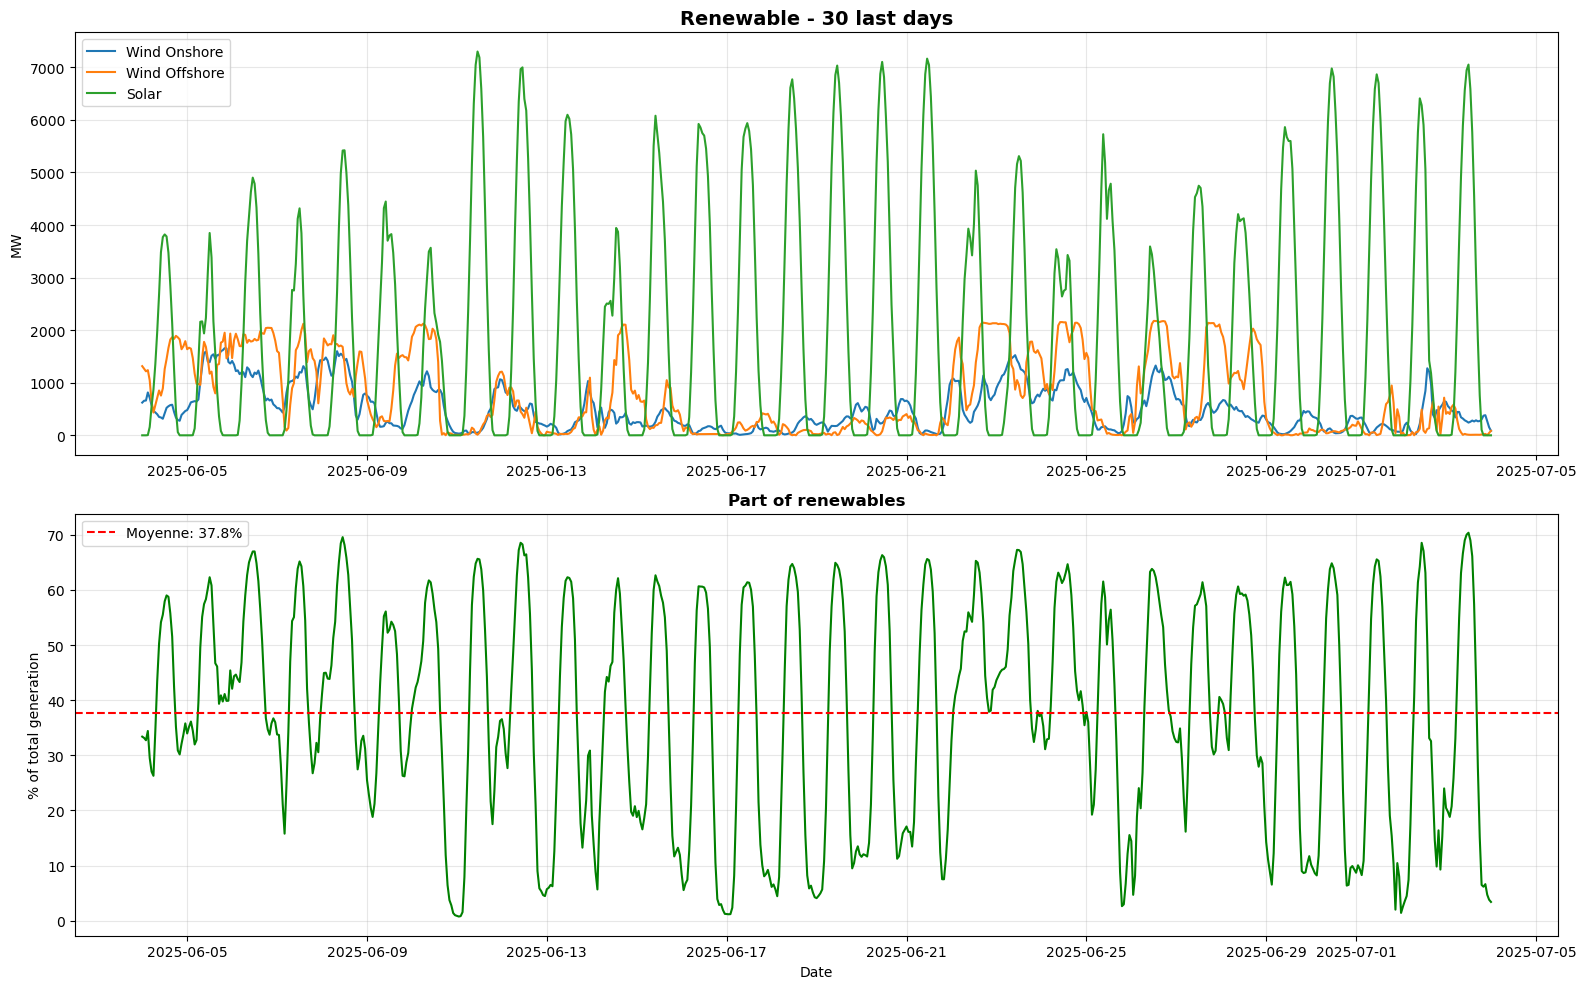

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))


axes[0].plot(recentbis['datetime'], recentbis['wind_onshore_actual'], label='Wind Onshore', linewidth=1.5)
axes[0].plot(recentbis['datetime'], recentbis['wind_offshore_actual'], label='Wind Offshore', linewidth=1.5)
axes[0].plot(recentbis['datetime'], recentbis['solar_actual'], label='Solar', linewidth=1.5)
axes[0].set_title('Renewable - 30 last days', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MW')
axes[0].legend()
axes[0].grid(alpha=0.3)


recentbis['renewable_share'] = ((recentbis['wind_onshore_actual'] + 
                              recentbis['wind_offshore_actual'] + 
                              recentbis['solar_actual']) / 
                             recentbis['total_gen_actual'] * 100)

axes[1].plot(recentbis['datetime'], recentbis['renewable_share'], color='green', linewidth=1.5)
axes[1].axhline(y=recentbis['renewable_share'].mean(), color='red', linestyle='--', 
                label=f'Moyenne: {recentbis["renewable_share"].mean():.1f}%')
axes[1].set_title('Part of renewables', fontsize=12, fontweight='bold')
axes[1].set_ylabel('% of total generation')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### It looks good, we can clearly see the regular patterns for the solar (July)
#### We can see the variability of the wind energy too

#### More generally, the second plot express how variable the renewable sources are

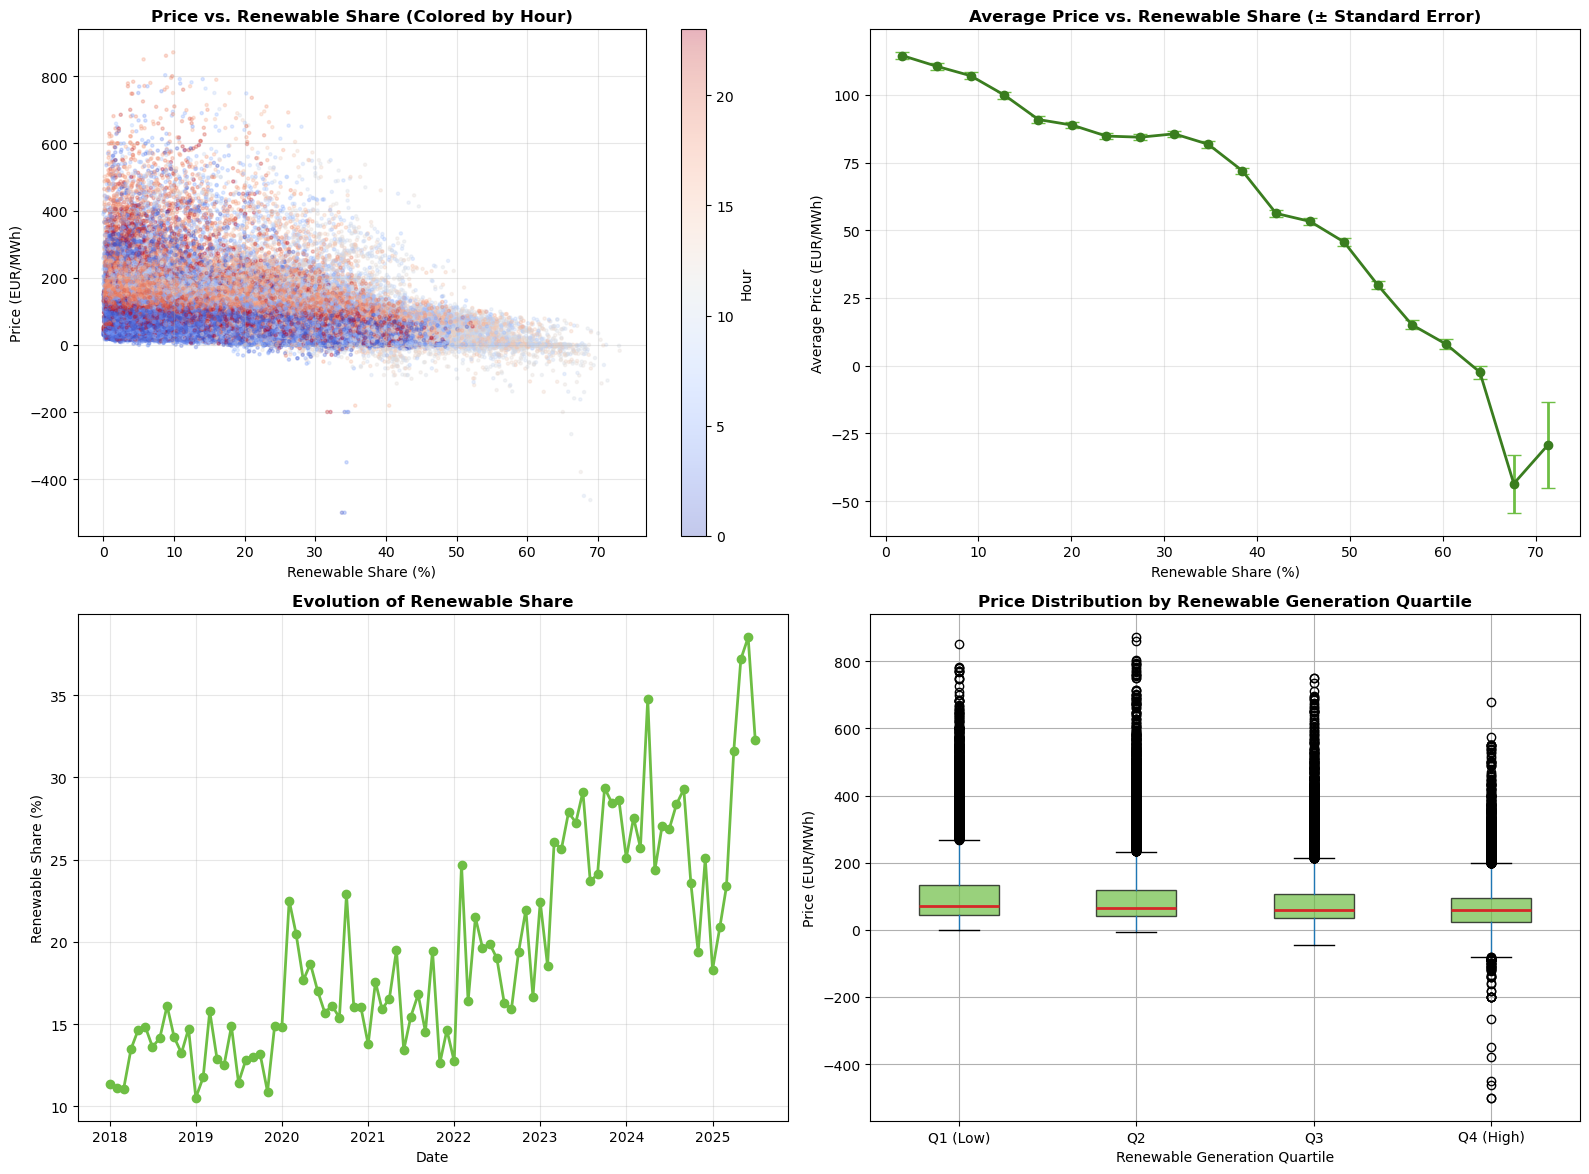

In [29]:
df_real['renewable_share'] = (df_real['wind_onshore_actual'] +
                             df_real['wind_offshore_actual'] +
                             df_real['solar_actual']) / df_real['total_gen_actual'] * 100

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

scatter = axes[0, 0].scatter(df_real['renewable_share'], df_real['price'],
                            alpha=0.3, s=5, c=df_real['hour'], cmap='coolwarm')
axes[0, 0].set_xlabel('Renewable Share (%)')
axes[0, 0].set_ylabel('Price (EUR/MWh)')
axes[0, 0].set_title('Price vs. Renewable Share (Colored by Hour)', fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 0], label='Hour')
axes[0, 0].grid(alpha=0.3)

bins = pd.cut(df_real['renewable_share'], bins=20)
binned = df_real.groupby(bins)['price'].agg(['mean', 'std', 'count'])
bin_centers = [interval.mid for interval in binned.index]
axes[0, 1].errorbar(bin_centers, binned['mean'], yerr=binned['std']/np.sqrt(binned['count']),
                    marker='o', capsize=5, linewidth=2, markersize=6, color=error_green, ecolor=green)
axes[0, 1].set_xlabel('Renewable Share (%)')
axes[0, 1].set_ylabel('Average Price (EUR/MWh)')
axes[0, 1].set_title('Average Price vs. Renewable Share (± Standard Error)', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

monthly_renewable = df_real.groupby(df_real['datetime'].dt.to_period('M'))['renewable_share'].mean()
axes[1, 0].plot(monthly_renewable.index.to_timestamp(), monthly_renewable.values,
                linewidth=2, color=green, marker='o')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Renewable Share (%)')
axes[1, 0].set_title('Evolution of Renewable Share', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

df_real['renewable_quartile'] = pd.qcut(df_real['renewable_share'], q=4,
                                        labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
df_real.boxplot(column='price', by='renewable_quartile', ax=axes[1, 1], patch_artist=True,
                boxprops=dict(facecolor=green, alpha=0.7),
                medianprops=dict(color=red, linewidth=2))
axes[1, 1].set_title('Price Distribution by Renewable Generation Quartile', fontweight='bold')
axes[1, 1].set_xlabel('Renewable Generation Quartile')
axes[1, 1].set_ylabel('Price (EUR/MWh)')
axes[1, 1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

#### The two upper plots shows something that we already know : the price decays when the renewable share rise.
#### The boxplot confirms this.
#### Lower left plot shows that the renewable share rose remarkabely since early 2020.

### Visualisation : price vs time

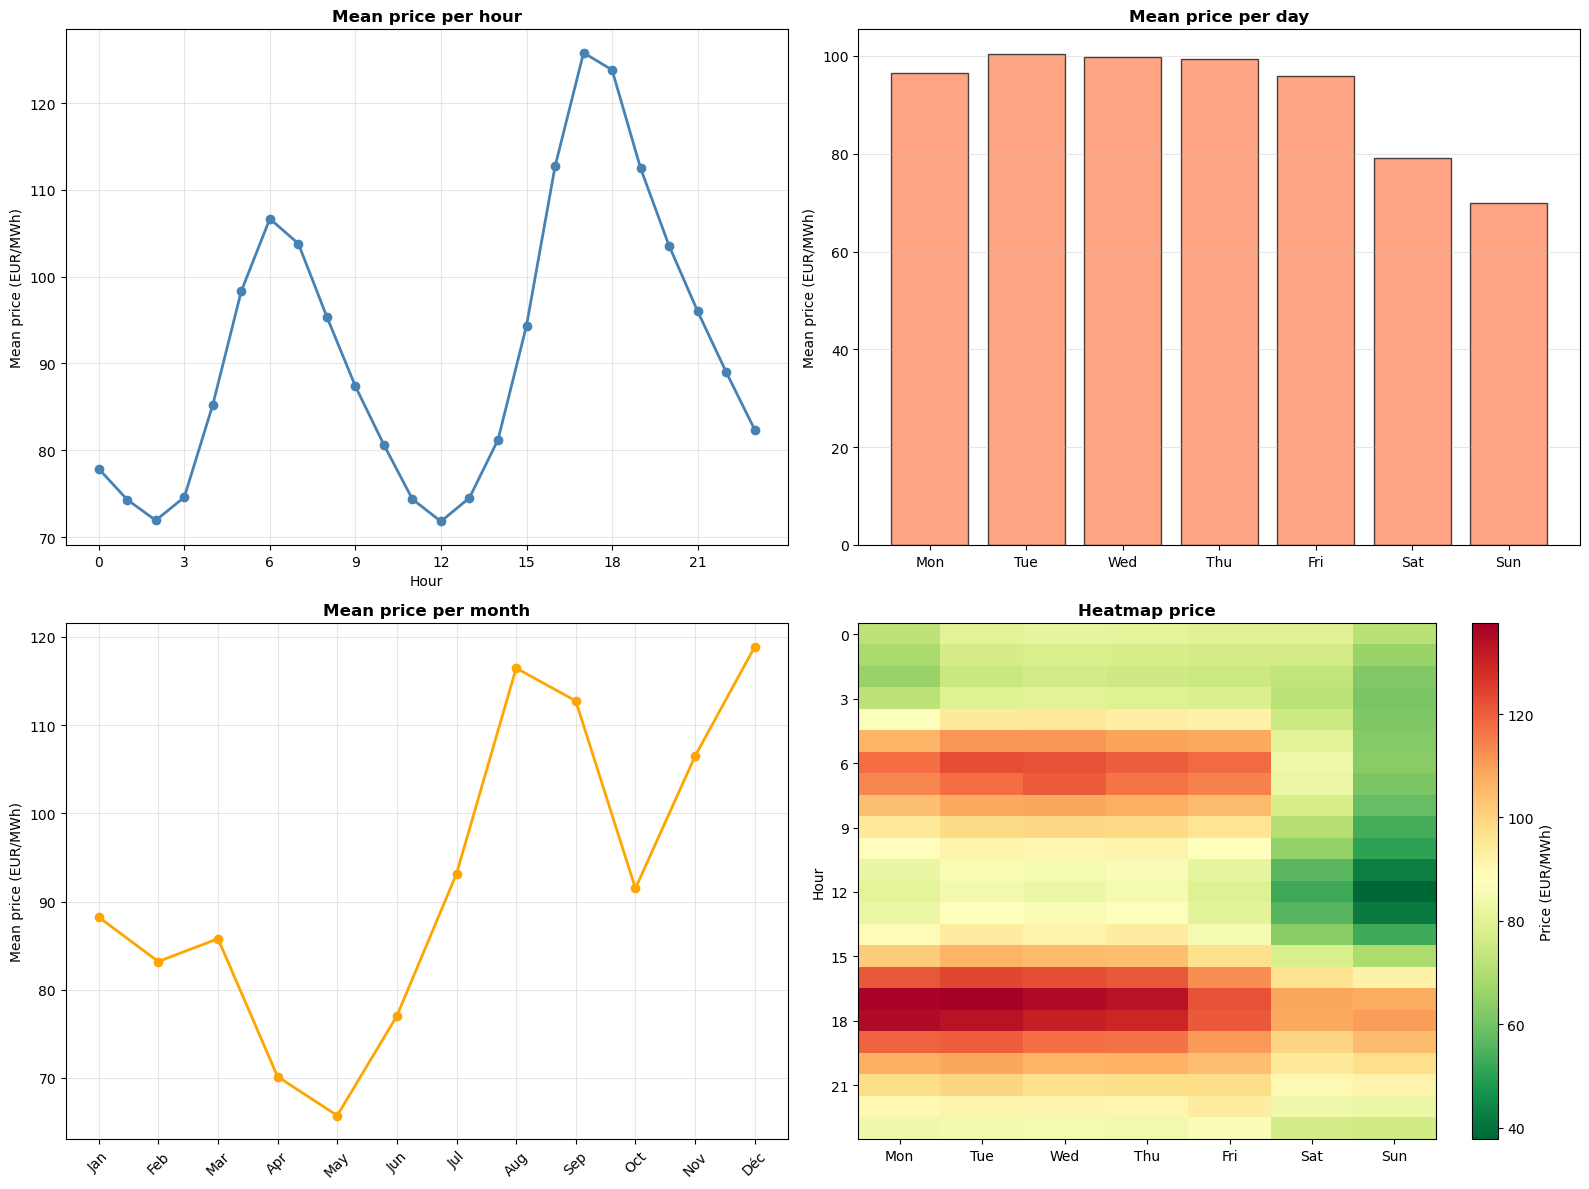

In [30]:
df_real['hour'] = df_real['datetime'].dt.hour
df_real['dayofweek'] = df_real['datetime'].dt.dayofweek
df_real['month'] = df_real['datetime'].dt.month

fig, axes = plt.subplots(2, 2, figsize=(16, 12))


hourly_mean = df_real.groupby('hour')['price'].mean()
axes[0, 0].plot(hourly_mean.index, hourly_mean.values, marker='o', linewidth=2, color='steelblue')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Mean price (EUR/MWh)')
axes[0, 0].set_title('Mean price per hour', fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 3))


daily_mean = df_real.groupby('dayofweek')['price'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), daily_mean.values, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(days)
axes[0, 1].set_ylabel('Mean price (EUR/MWh)')
axes[0, 1].set_title('Mean price per day', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)


monthly_mean = df_real.groupby('month')['price'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Déc']
axes[1, 0].plot(range(1, 13), monthly_mean.values, marker='o', linewidth=2, color='orange')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(months, rotation=45)
axes[1, 0].set_ylabel('Mean price (EUR/MWh)')
axes[1, 0].set_title('Mean price per month', fontweight='bold')
axes[1, 0].grid(alpha=0.3)


pivot = df_real.pivot_table(values='price', index='hour', columns='dayofweek', aggfunc='mean')
im = axes[1, 1].imshow(pivot.values, cmap='RdYlGn_r', aspect='auto')
axes[1, 1].set_yticks(range(0, 24, 3))
axes[1, 1].set_yticklabels(range(0, 24, 3))
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(days)
axes[1, 1].set_ylabel('Hour')
axes[1, 1].set_title('Heatmap price', fontweight='bold')
plt.colorbar(im, ax=axes[1, 1], label='Price (EUR/MWh)')

plt.tight_layout()
plt.show()

#### Seems counterintuitive : prices are lower in the weekend (=> less load on the grid)
        -> Why ? Because our data take in account all the sectors ! Industries doesnt use energy in the weekend 

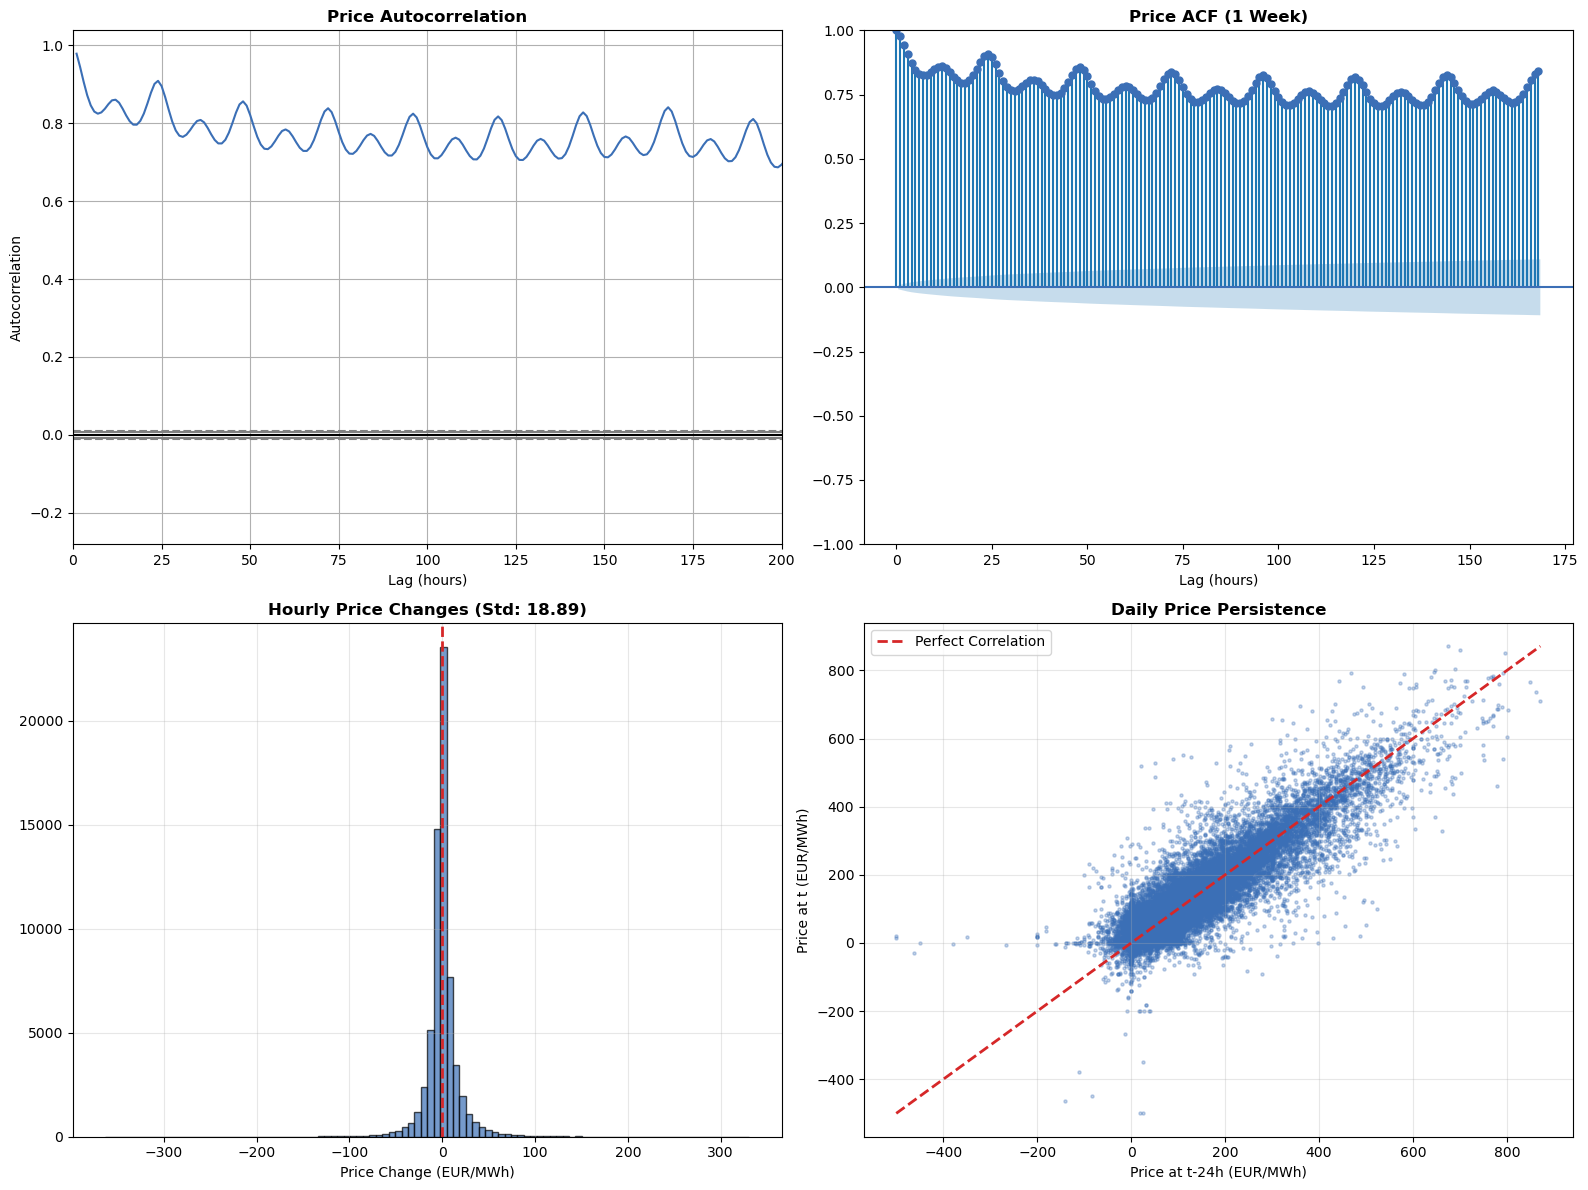


Price(t) vs Price(t-24h) Correlation: 0.909


In [31]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

autocorrelation_plot(df_real['price'].dropna(), ax=axes[0, 0], color=blue)
axes[0, 0].set_title('Price Autocorrelation', fontweight='bold')
axes[0, 0].set_xlim([0, 200])
axes[0, 0].set_xlabel('Lag (hours)')
axes[0, 0].set_ylabel('Autocorrelation')

plot_acf(df_real['price'].dropna(), lags=168, ax=axes[0, 1], color=blue)
axes[0, 1].set_title('Price ACF (1 Week)', fontweight='bold')
axes[0, 1].set_xlabel('Lag (hours)')

df_real['price_diff'] = df_real['price'].diff()
axes[1, 0].hist(df_real['price_diff'].dropna(), bins=100, edgecolor='black', alpha=0.7, color=blue)
axes[1, 0].set_xlabel('Price Change (EUR/MWh)')
std_diff = df_real['price_diff'].std()
axes[1, 0].set_title(f'Hourly Price Changes (Std: {std_diff:.2f})', fontweight='bold')
axes[1, 0].axvline(0, color=red, linestyle='--', linewidth=2)
axes[1, 0].grid(alpha=0.3)

df_real['price_lag24'] = df_real['price'].shift(24)
axes[1, 1].scatter(df_real['price_lag24'], df_real['price'], alpha=0.3, s=5, color=blue)
price_range = [df_real['price'].min(), df_real['price'].max()]
axes[1, 1].plot(price_range, price_range, color=red, linestyle='--', linewidth=2, label='Perfect Correlation')
axes[1, 1].set_xlabel('Price at t-24h (EUR/MWh)')
axes[1, 1].set_ylabel('Price at t (EUR/MWh)')
axes[1, 1].set_title('Daily Price Persistence', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

corr_24h = df_real[['price', 'price_lag24']].corr().iloc[0, 1]
print(f"\nPrice(t) vs Price(t-24h) Correlation: {corr_24h:.3f}")

#### Both upper plots show how the price is autocorrelated. But the second one shows the confidence interval
#### More generally, this figure shows how the price change by hours. There is a really strong correlation from day d to day d+1

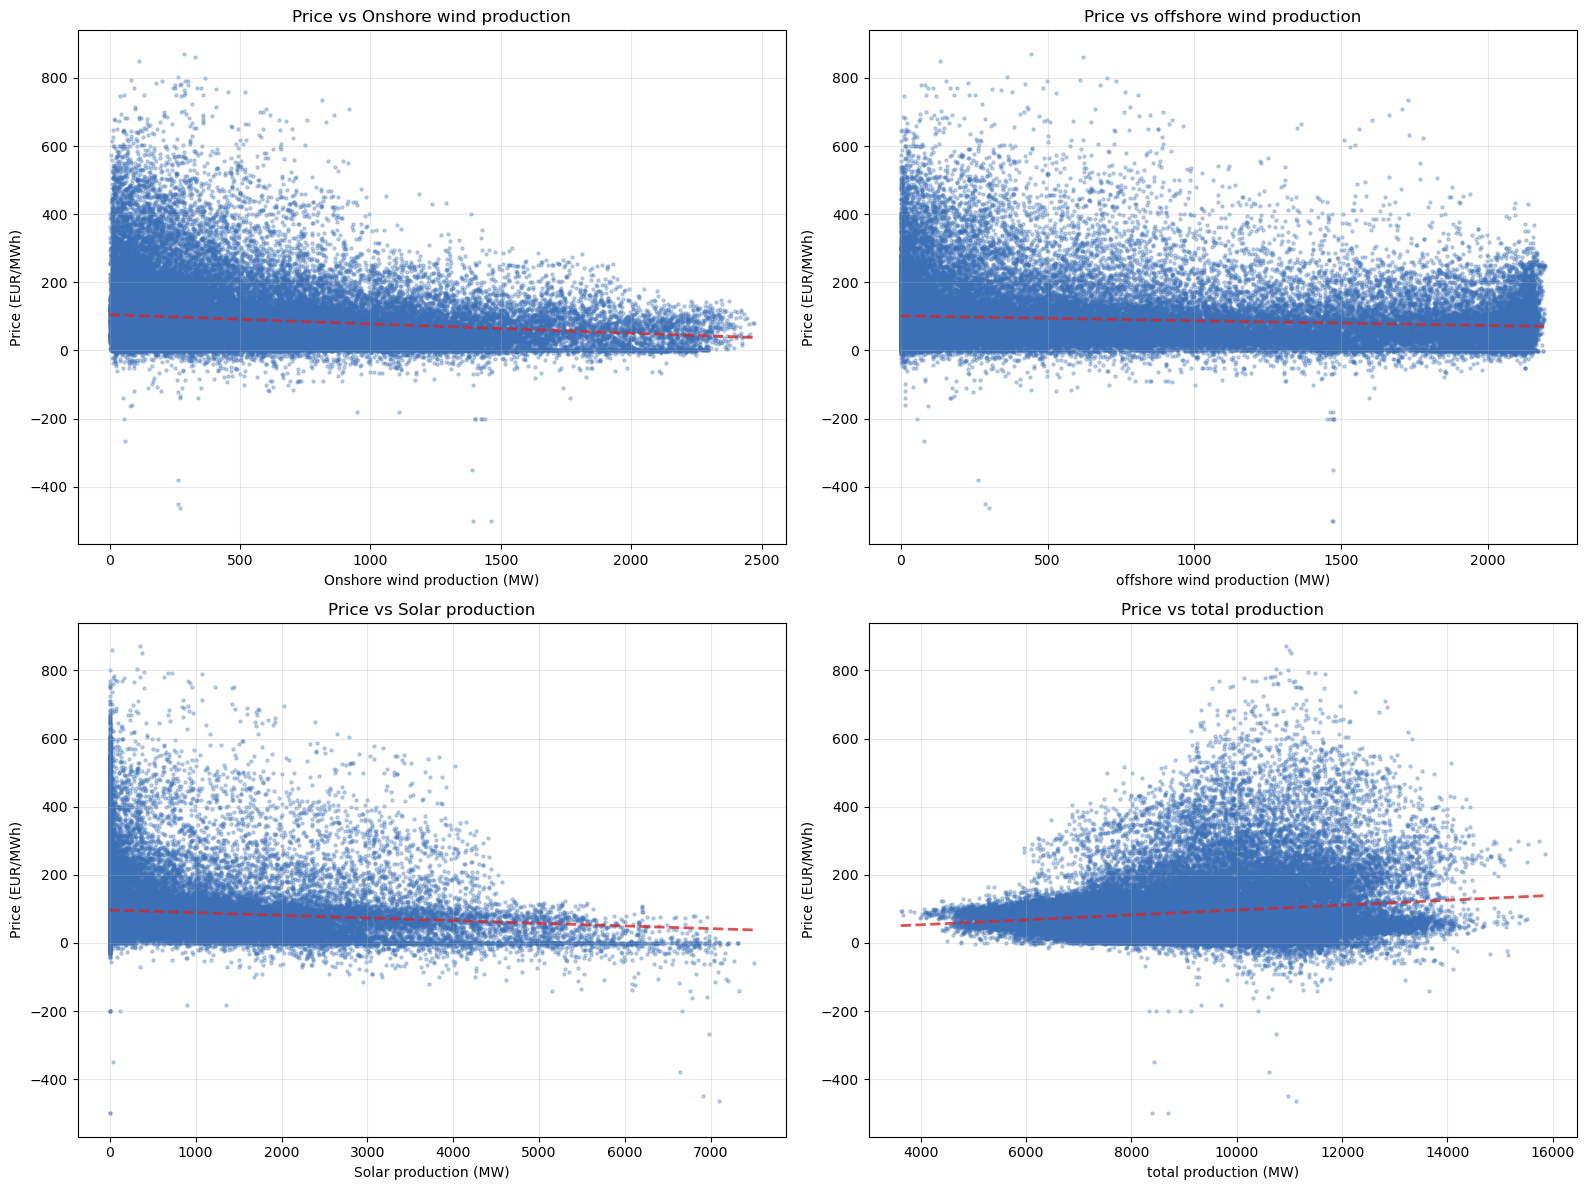

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

variables = [
    ('wind_onshore_actual', 'Onshore wind production'),
    ('wind_offshore_actual', 'offshore wind production'),
    ('solar_actual', 'Solar production'),
    ('total_gen_actual', 'total production')
]

for idx, (col, title) in enumerate(variables):
    ax = axes[idx//2, idx%2]
    ax.scatter(df_real[col], df_real['price'], alpha=0.3, s=5, color=blue)
    ax.set_xlabel(f'{title} (MW)')
    ax.set_ylabel('Price (EUR/MWh)')
    ax.set_title(f'Price vs {title}')
    
    # Ajouter ligne de tendance
    valid_data = df_real[[col, 'price']].dropna()
    z = np.polyfit(valid_data[col], valid_data['price'], 1)
    p = np.poly1d(z)
    x_sorted = np.sort(valid_data[col])
    ax.plot(x_sorted, p(x_sorted), color=red, linestyle='--', alpha=0.8, linewidth=2)
    
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Visualisation : price vs load

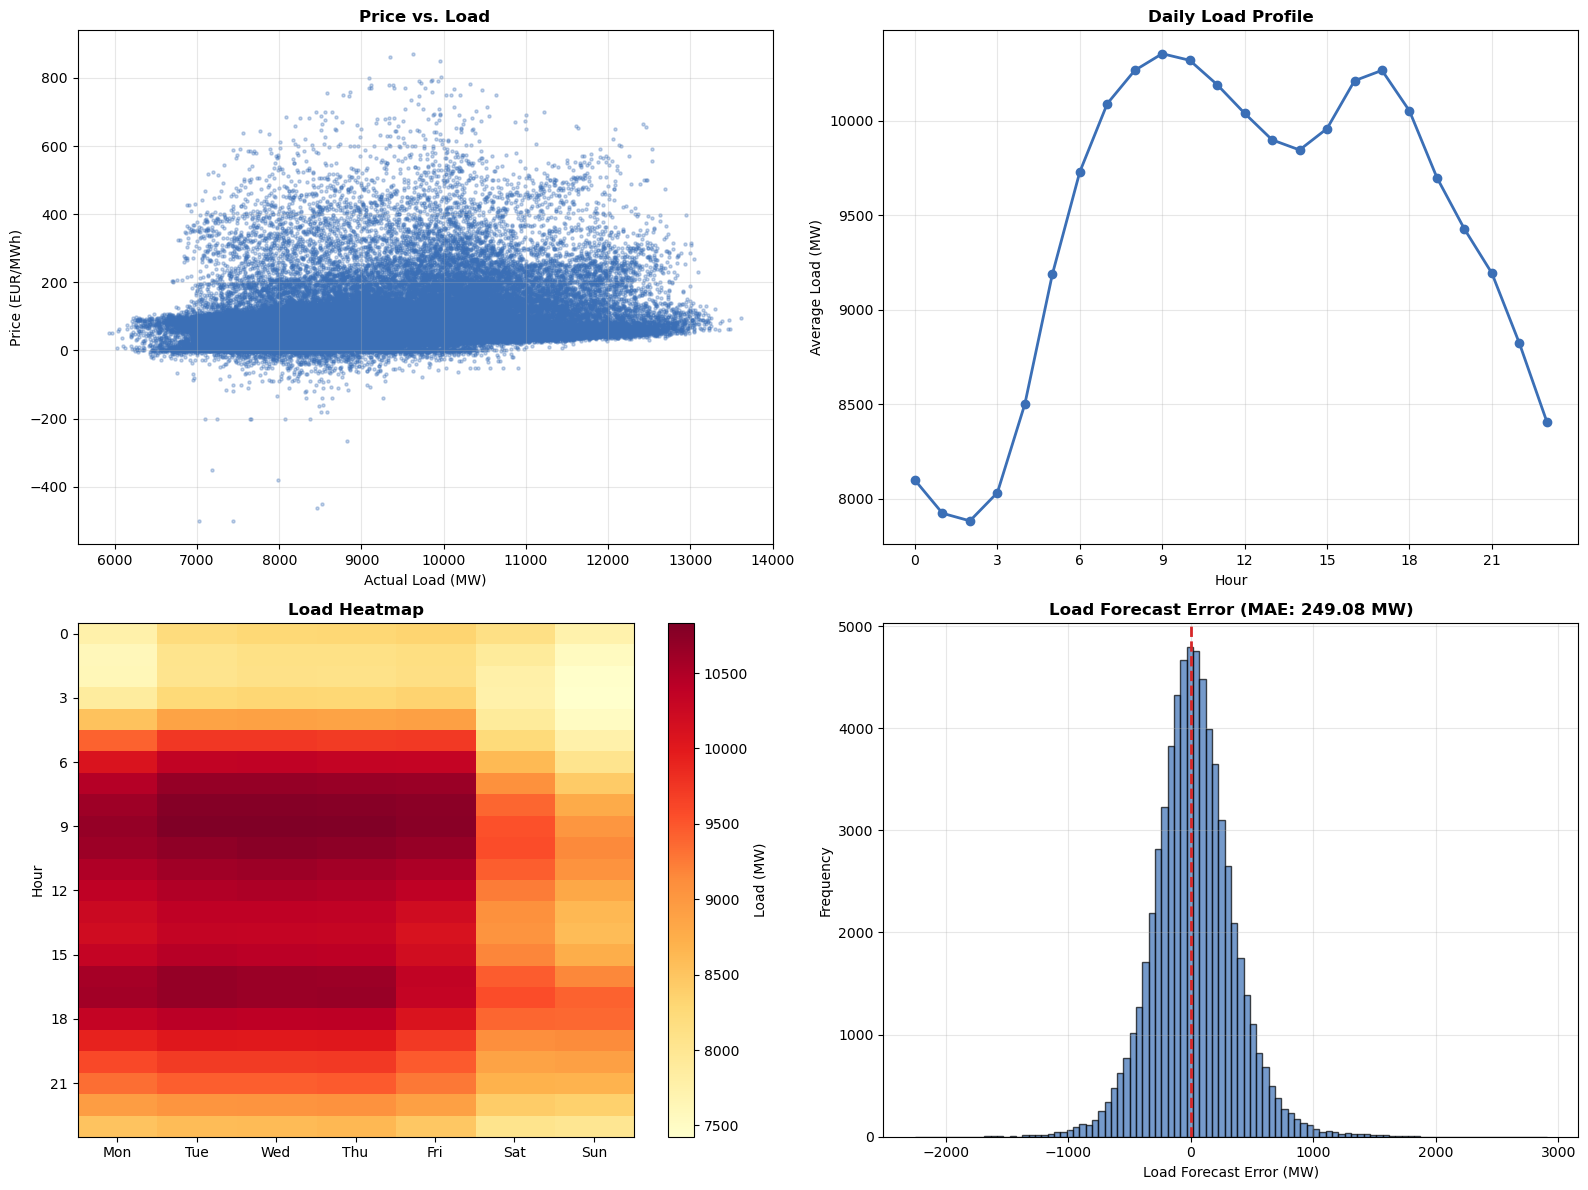

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


axes[0, 0].scatter(df_real['load_actual'], df_real['price'], alpha=0.3, s=5, color=blue)
axes[0, 0].set_xlabel('Actual Load (MW)')
axes[0, 0].set_ylabel('Price (EUR/MWh)')
axes[0, 0].set_title('Price vs. Load', fontweight='bold')
axes[0, 0].grid(alpha=0.3)


hourly_load = df_real.groupby('hour')['load_actual'].mean()
axes[0, 1].plot(hourly_load.index, hourly_load.values, marker='o', linewidth=2,
                color=blue, markersize=6)
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Average Load (MW)')
axes[0, 1].set_title('Daily Load Profile', fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(range(0, 24, 3))

pivot_load = df_real.pivot_table(values='load_actual', index='hour', columns='dayofweek', aggfunc='mean')
im = axes[1, 0].imshow(pivot_load.values, cmap='YlOrRd', aspect='auto')
axes[1, 0].set_yticks(range(0, 24, 3))
axes[1, 0].set_yticklabels(range(0, 24, 3))
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 0].set_ylabel('Hour')
axes[1, 0].set_title('Load Heatmap', fontweight='bold')
plt.colorbar(im, ax=axes[1, 0], label='Load (MW)')


axes[1, 1].hist(df_real['load_error'], bins=100, edgecolor='black', alpha=0.7, color=blue)
axes[1, 1].axvline(0, color=red, linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Load Forecast Error (MW)')
axes[1, 1].set_ylabel('Frequency')
load_mae = abs(df_real['load_error']).mean()
axes[1, 1].set_title(f'Load Forecast Error (MAE: {load_mae:.2f} MW)', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Surprisingly, the scatter plot of the load vs the price is not as sharp as it can initially be thought ! 
#### Upper right and lower left plots shows basically the same thing but from different angles, the daily load profile is as it is said in the title a "profile". The heatmap gives more information by having a "from above" view. This heatmap is linked to the price heatmap, as the scatter plot suggests. 
#### The load forecast error distribution is Gaussian shaped !

### Visualisation : energy in general + nuclear

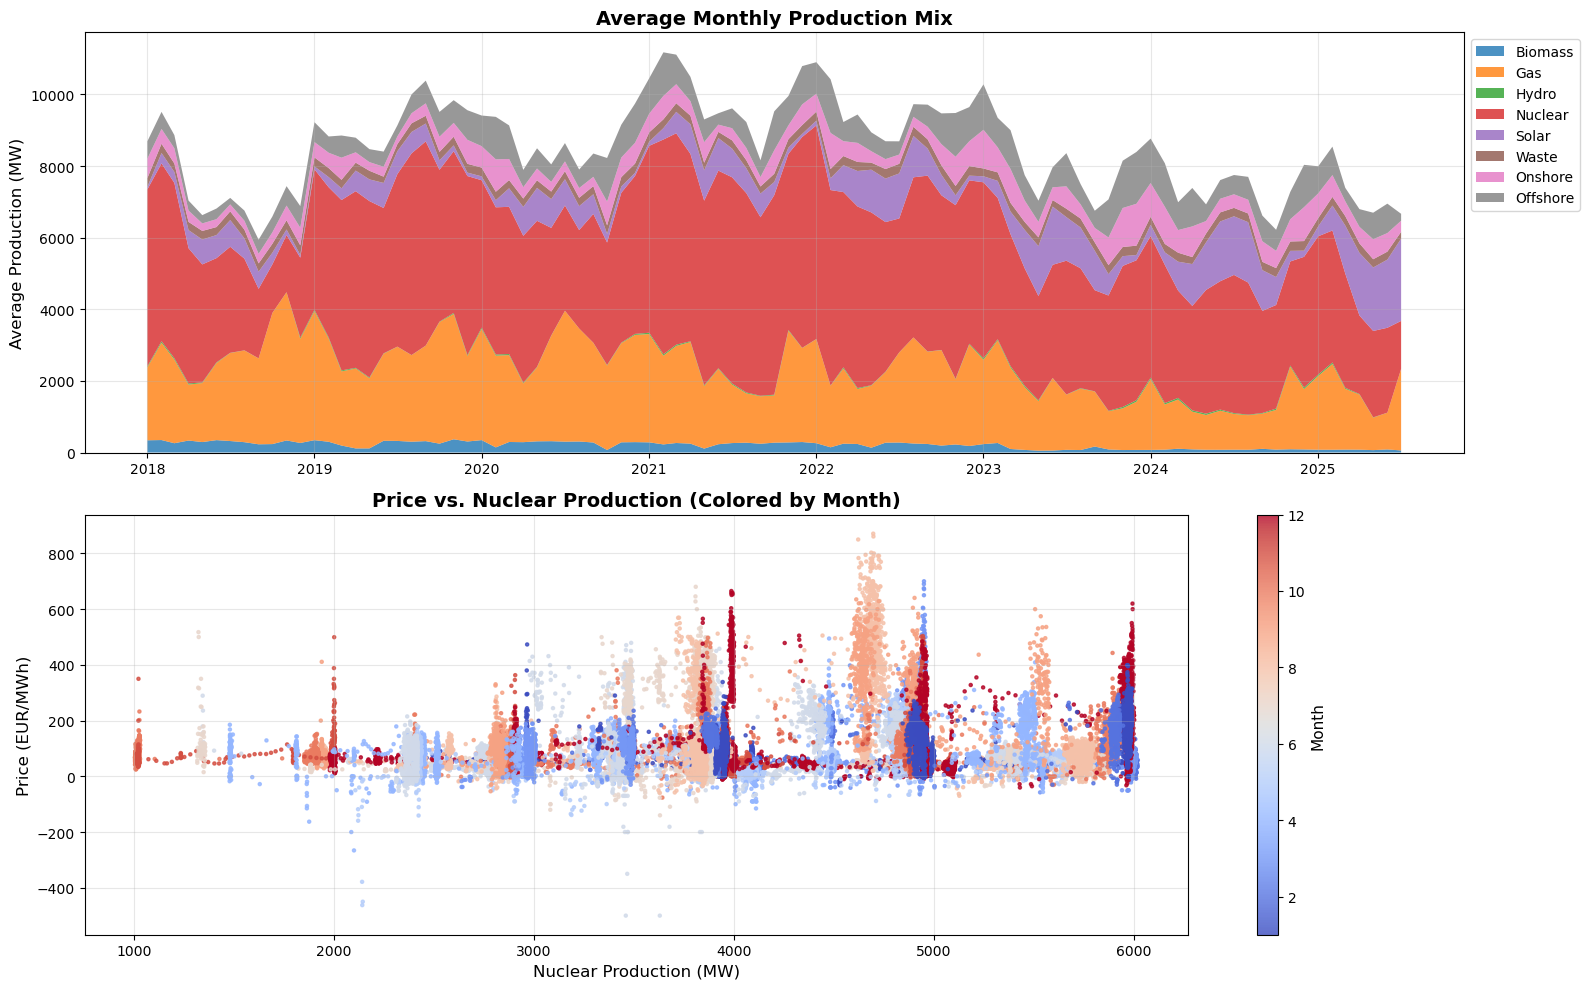

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

production_cols = ['gen_biomass', 'gen_gas', 'gen_hydro_river',
                   'gen_nuclear', 'gen_solar_actual', 'gen_waste', 'wind_onshore_actual', 'wind_offshore_actual']
monthly_prod = df_real.groupby(df_real['datetime'].dt.to_period('M'))[production_cols].mean()


axes[0].stackplot(monthly_prod.index.to_timestamp(),
                  [monthly_prod[col] for col in production_cols],
                  labels=['Biomass', 'Gas', 'Hydro', 'Nuclear', 'Solar', 'Waste', 'Onshore', 'Offshore'], alpha=0.8)
axes[0].set_ylabel('Average Production (MW)', fontsize=12)
axes[0].set_title('Average Monthly Production Mix', fontweight='bold', fontsize=14)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0].grid(alpha=0.3)

scatter = axes[1].scatter(df_real['gen_nuclear'], df_real['price'],
                          alpha=0.8, s=5, c=df_real['month'], cmap='coolwarm')
axes[1].set_xlabel('Nuclear Production (MW)', fontsize=12)
axes[1].set_ylabel('Price (EUR/MWh)', fontsize=12)
axes[1].set_title('Price vs. Nuclear Production (Colored by Month)', fontweight='bold', fontsize=14)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Month', fontsize=11)
axes[1].grid(alpha=0.3)




plt.tight_layout()
plt.show()

#### Upper plot shows the average monthly generation mix over time. Nuclear production is clearly the main part of this mix. 

#### By just looking at the scatter plot, one could think that when nuclear production rise, volatility rises too. That's right but there is a nuance : energy markets are really volatile and nuclear production is most of the time really high -> there are way more points on the right than on the left !

#### Moreover, The colour gradient also highlights strong seasonality, with some months (e.g. winter) concentrating more of the extreme high-price events at given nuclear levels.

## CSV Export

In [35]:
output_path = '/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/processed/alldata.csv'

df_real.to_csv(output_path)